In [9]:
# Import necessary librairies
import gc 
import numpy as np # linear algebra
from numpy import hstack
from numpy import array
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import norm, skew #for some statistics

# Definitions
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
pd.set_option('display.max_columns', 100)    #Display upto 100 columns 
pd.set_option('display.max_rows', 100) 
%matplotlib inline

# Check the files available in the directory
import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')        

Scikit-Learn 1.0 or higher is required for this project due to the introduction of Feature Names Support among other [updates](https://scikit-learn.org/stable/auto_examples/release_highlights/plot_release_highlights_1_0_0.html). These updates allow easier use of Sklearn `Pipeline` when creating an end-to-end machine learning pipeline. 

In [1]:


# Confirm sklearn version
from sklearn import __version__
__version__

'1.7.2'

# Import Zillow Datasets

Due to the setup of the Zillow competition, the training dataset is present in two different CSVs, one for each of 2016 and 2017 properties along with a corresponding CSV for each that contains the target variable. 

Zillow is asking us to predict the log-error between their Zestimate and the actual sale price, given all the features of a home. The log error is defined as
`logerror = log(Zestimate) - log(SalePrice)` 

In [2]:
import os

HOUSING_PATH = os.path.join("zillow-prize-1")
print(HOUSING_PATH)

zillow-prize-1


In [2]:
import os
import pandas as pd

HOUSING_PATH = os.path.join("zillow-prize-1")
PROPERTIES_2016 = 'properties_2016.csv'
PROPERTIES_2017 = 'properties_2017.csv'
TRAIN_2016 = 'train_2016_v2.csv'
TRAIN_2017 = 'train_2017.csv'
    
def load_housing_data(housing_path=HOUSING_PATH):
    properties_2016 = pd.read_csv(os.path.join(housing_path, PROPERTIES_2016))
    properties_2017 = pd.read_csv(os.path.join(housing_path, PROPERTIES_2017))
    train_2016 = pd.read_csv(os.path.join(housing_path, TRAIN_2016))
    train_2017 = pd.read_csv(os.path.join(housing_path, TRAIN_2017))

    # Left join will ignore all properties that do not have a logerror (target variable) associated with them
    train_2016 = pd.merge(train_2016, properties_2016, how = 'left', on = 'parcelid')
    train_2017 = pd.merge(train_2017, properties_2017, how = 'left', on = 'parcelid')
    
    # Union data for 2016 and 2017 into one dataframe
    all_properties = pd.concat([properties_2016, properties_2017], ignore_index=True)
    all_training = pd.concat([train_2016, train_2017], ignore_index=True)
    return all_properties, all_training

In [3]:
all_properties, housing = load_housing_data()
housing.head()

/var/folders/x9/g11f20ps45b0l8hqg5022bnr0000gp/T/ipykernel_72880/3189008271.py:11: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  properties_2016 = pd.read_csv(os.path.join(housing_path, PROPERTIES_2016))
/var/folders/x9/g11f20ps45b0l8hqg5022bnr0000gp/T/ipykernel_72880/3189008271.py:12: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  properties_2017 = pd.read_csv(os.path.join(housing_path, PROPERTIES_2017))


,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


In [4]:
print("Total Properties Shape: {}".format(all_properties.shape))
print("-"*50)
housing.info()

Total Properties Shape: (5970434, 58)
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167888 entries, 0 to 167887
Data columns (total 60 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   parcelid                      167888 non-null  int64  
 1   logerror                      167888 non-null  float64
 2   transactiondate               167888 non-null  object 
 3   airconditioningtypeid         53788 non-null   float64
 4   architecturalstyletypeid      468 non-null     float64
 5   basementsqft                  93 non-null      float64
 6   bathroomcnt                   167854 non-null  float64
 7   bedroomcnt                    167854 non-null  float64
 8   buildingclasstypeid           31 non-null      float64
 9   buildingqualitytypeid         107173 non-null  float64
 10  calculatedbathnbr             166056 non-null  float64
 11  decktypeid     

**Observations based on the information above:** 
- Total number of properties is 5.97 million, much smaller than the training dataset with transactions information for 335k entries
- Variable types distribution: 53 Float64, 6 Object (Categorical) and 1 Integer (`ParcelID`)
- Lots of variables contain missing data - these features are candidates for **Imputation or Dropping**. 

In [5]:
# Check for and drop duplicates in training dataset
def check_duplicates(housing): 
    idsUnique = len(housing[['parcelid', 'transactiondate']].value_counts())
    idsTotal = housing.shape[0]
    idsDupli = idsTotal - idsUnique
    print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")
    
def drop_duplicates(housing):
    # Drop all duplicate entries which have the same parcelID and Transaction Date
    print("Dropping all duplicates based on parcelid and transactiondate...")
    return housing.drop_duplicates(subset=['parcelid', 'transactiondate'], keep='last', ignore_index=True) 

In [6]:
# Check for and drop duplicates
check_duplicates(housing)
housing = drop_duplicates(housing)

# Validate 
check_duplicates(housing)

There are 0 duplicate IDs for 167888 total entries
Dropping all duplicates based on parcelid and transactiondate...
There are 0 duplicate IDs for 167888 total entries


## Target Variable 

`logerror` is the variable we need to predict. So let's do some analysis on this variable first. 

In [7]:
y = housing.logerror

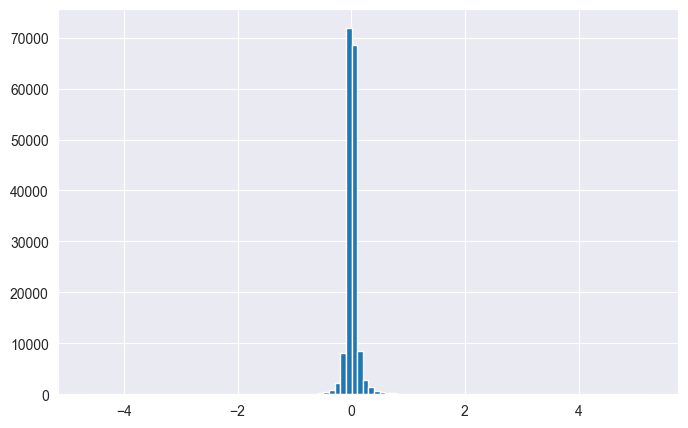

In [10]:
y.hist(bins=100, figsize=(8,5))
plt.show()

In [11]:
y.describe()

count   167888.000
mean         0.014
std          0.166
min         -4.655
25%         -0.025
50%          0.006
75%          0.039
max          5.263
Name: logerror, dtype: float64


 mu = 0.01 and sigma = 0.17



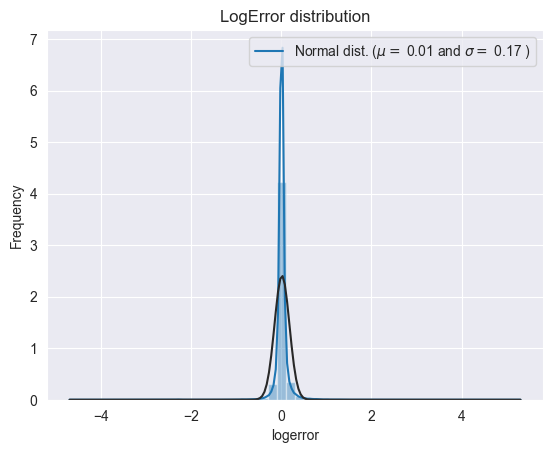

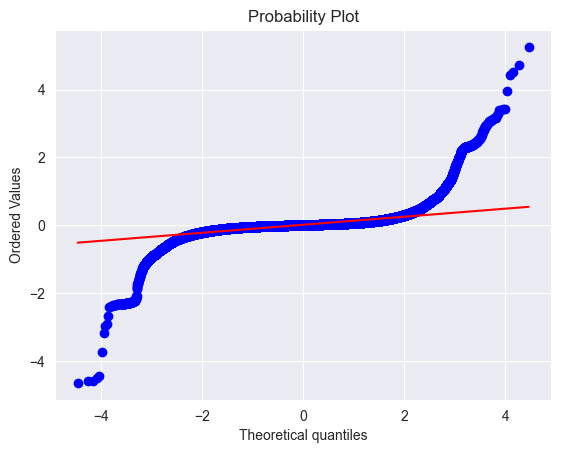

In [12]:
sns.distplot(y , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('LogError distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y, plot=plt)
plt.show()

The target variable is skewed and contains outliers. There are two options to treat this: 
- For most cases, since (linear) models love normally distributed data, we would have transformed this variable through a log transformation to make it more normally distributed. 
- **However, given the unique nature of this specific problem where we are trying to predict the errors that the Zillow model makes when estimating house values, it makes more sense to ignore the cases where the Zillow model is horribly wrong - rather than try to learn the unique cases where it is way off.**



### Dropping Outliers 

Since the data is mostly normally distributed outside of the outliers, we will drop all values that are more than 2.5 standard deviations away from the mean. For reference, for the standard normal distribution, 68% of the observations lie within 1 standard deviation of the mean; 95% lie within two standard deviation of the mean; and 99.9% lie within 3 standard deviations of the mean.

In [13]:
highest_thres = y.mean() + 2.5*y.std()
lowest_thres = y.mean() - 2.5*y.std()
print("Highest allowed",highest_thres)
print("Lowest allowed", lowest_thres)

Highest allowed 0.42817114871087053
Lowest allowed -0.40035853636838675


In [14]:
# Only the training set outliers will be dropped (not validation or testing set to ensure model performs well on outliers too)
y = y[y > lowest_thres]
y = y[y < highest_thres]

# Update original Housing dataframe 
housing = housing[housing.logerror > lowest_thres]
housing = housing[housing.logerror < highest_thres]

In [15]:
# Drop rows containing either 75% or more NaN Values
percent = 75.0 
min_count =  int(((100-percent)/100)*housing.shape[1] + 1)
housing = housing.dropna(axis=0, thresh=min_count)
housing.shape

(164538, 60)

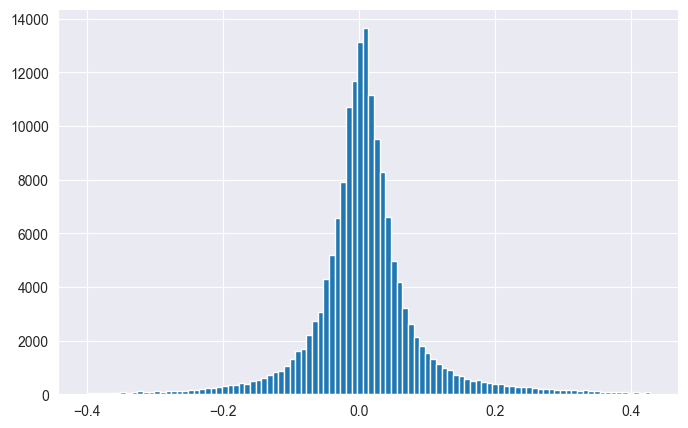

In [16]:
y.hist(bins=100, figsize=(8,5))
plt.show()


 mu = 0.01 and sigma = 0.08



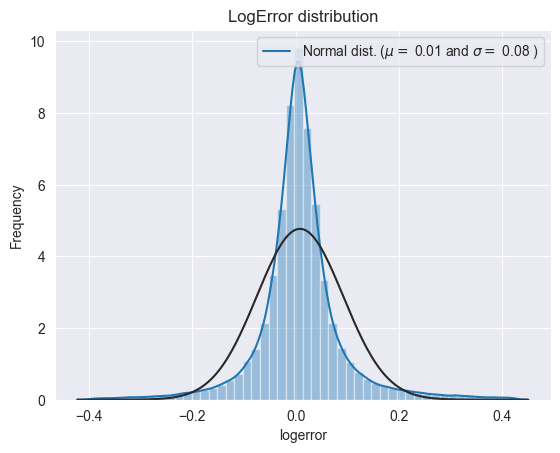

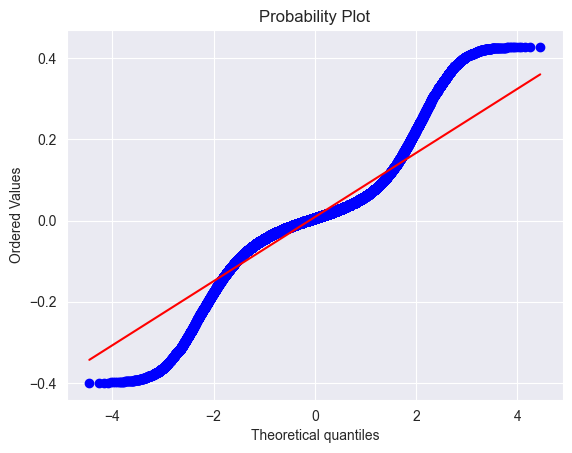

In [17]:
#Check the new distribution 
sns.distplot(y , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('LogError distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y, plot=plt)
plt.show()

The skew seems now corrected and the data appears better normally distributed.

# Create Test / Train Datasets 

To avoid **data snooping** bias by overfitting to the test set, we need to create a test set, put it aside and never look at it. The most basic solution is to pick some instances randomly, typically 20% of the dataset (or less if your dataset is very large), and set them aside. 

- **Issue with approach**: If you run the program again, it will generate a different test set! Over time, you (or your Machine Learning algorithms) will get to see the whole dataset, which is what you want to avoid.
- **Possible Solution**: To have a stable train/test split even after updating the dataset, a common solution is to use each instance’s identifier to decide whether or not it should go in the test set (assuming instances have a unique and immutable identifier).
    - For example, you could compute a hash of each instance’s identifier and put that instance in the test set if the hash is lower than or equal to 20% of the maximum hash value. This ensures that the test set will remain consistent across multiple runs, even if you refresh the dataset. The new test set will contain 20% of the new instances, but it will not contain any instance that was previously in the training set.

**Since `parcelid` is a unique identifier for each instance in the housing dataset, we can use it to implement the hash strategy outlined above.**


In [18]:
from zlib import crc32
from sklearn.model_selection import train_test_split 

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    
    train_set = data.loc[~in_test_set]
    test_set = data.loc[in_test_set]
    
    X_train = train_set.drop("logerror", axis=1)
    y_train = train_set["logerror"].copy()
    X_test = test_set.drop("logerror", axis=1)
    y_test = test_set["logerror"].copy()
    return X_train, X_test, y_train, y_test

X_other, X_test, y_other, y_test = split_train_test_by_id(housing, 0.1, "parcelid")
print(f"Other Dataset Shape: {X_other.shape}; Test Dataset Shape: {X_test.shape}")

Other Dataset Shape: (148111, 59); Test Dataset Shape: (16427, 59)


Next step is to further split `X_train, y_train` into Training and Validation Datasets. This is because:
- The models will be trained on the Training Set and compared to other models using the Validation Set. The Validation Set is used during the iterative process of model creation to validate the performance of the models being created. 
- On the other hand, the test set is kept hidden until the **final** step when the fully tuned machine learning algorithm is ready for deployment. 

In [19]:
# Split X_other into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_other, y_other, train_size=0.9, random_state=42)
print(f"Training Dataset Shape: {X_train.shape}")    # 81% of instances are in training 
print(f"Test Dataset Shape: {X_test.shape}")         # 10% of instances are in test 
print(f"Validation Dataset Shape: {X_val.shape}")    # 9% of instances are in validation 

Training Dataset Shape: (133299, 59)
Test Dataset Shape: (16427, 59)
Validation Dataset Shape: (14812, 59)


In [20]:
# Clear memory
del all_properties, housing; gc.collect()

26476

# Data Preprocessing Pipelines

As observed earlier, the final training dataset is missing values for many variables. The next step is to proceed sequentially through features with missing values and **either drop or impute values** based on the information available followed by performing **feature engineering**.

**Note: This is the LONGEST and MOST TEDIOUS section of the notebook where we create a Scikit-Learn Pipeline for every single preprocessing done on the data. Despite the tediousness in creating these individual pipelines, the final product pays dividends instantly as:** 
- You can reuse the modular code in future projects for preprocessing. 
- You can test different preprocessing combinations for each model easily to find the most optimized result
- Your code is easier to understand for others and is easier to deploy in production setting
- Finally, it forces you to stick to best coding practices in your data science projects

### Missing Data

In [195]:
all_data_na = (X_train.isnull().sum() / len(X_train)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data[:35]

,Missing Ratio
buildingclasstypeid,99.986
finishedsquarefeet13,99.958
basementsqft,99.948
storytypeid,99.948
yardbuildingsqft26,99.905
fireplaceflag,99.763
architecturalstyletypeid,99.717
typeconstructiontypeid,99.685
finishedsquarefeet6,99.537
decktypeid,99.240


In [21]:
print ("Features with one unique value!!")
exclude_unique = []
for c in X_train.columns:
    num_uniques = len(X_train[c].unique())
    if X_train[c].isnull().sum() != 0:
        num_uniques -= 1
    if num_uniques == 1:
        exclude_unique.append(c)
print(exclude_unique)

Features with one unique value!!
['decktypeid', 'hashottuborspa', 'poolcnt', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'storytypeid', 'fireplaceflag', 'taxdelinquencyflag']


### Drop Candidates 



The following variables are dropped instead of being imputed due to extremely high proportion of missing values making it impractical to impute based on such a small smaple. 

- **finishedsquarefeet13**: Data description says 'Perimeter Living Area'. Over 99% of the dataset is missing values.
- **finishedsquarefeet15**: Data description says 'Total area'. Over 96% of the dataset is missing values.
- **finishedfloor1squarefeet**: Over 92% of the dataset is missing values.
- **finishedsquarefeet50**: Over 92% of the dataset is missing values.
- **storytypeid**: Data description states 35 possible values for the Story Type. Over 99% of the dataset is missing values.
- **buildingclasstypeid**: With over 99.8% of the dataset missing, imputing won't contribute any new information. 
- **architecturalstyletypeid**: Data description states 27 possible values. Over 99% of the dataset is missing values.
- **typeconstructiontypeid**: Data description states 18 possible values. Over 99% of the dataset is missing values.
- **finishedsquarefeet6**: Data description states 'Base unfinished and finished area'. However, with over 99% of data missing, feature is dropped. 
- **numberofstories**: With over 77% of the missing values and no one value dominating the variable distribution, it is impractical to impute and introduce incorrect information. 
- **rawcensustractandblock, censustractandblock**: With almost 58k unique values, these features are being dropped until further research can be done into incorporating information from them in the model algorithm. 
- **assessmentyear**: Dropping as the variable has only one unique value in the dataset.
- **parcelid, transactiondate**: This variable is not available when trying to predict target variable `logerror` 
- **basementsqft, yardbuildingsqft26**: Dropping due to over 96% of data missing.  

<br>

#### Duplicate Features 

Following features are dropped as they represent information already available from another variable in the dataset. 
- **pooltypeid10, hashottuborspa**: Duplicate information is present in `pooltypeid2` feature.
- **pooltypeid7**: Data description states 'Pool without Hot Tub', duplicate information is present in `pooltypeid2` feature which is boolean for 'Pool with Spa/Hot Tub'
- **fireplaceflag**: Duplicate information is present in `fireplacecnt` feature with `fireplaceflag` having a higher missing ratio. 
- **threequarterbathnbr, calculatedbathnbr, fullbathcnt**: Duplicate information is present in `bathroomcnt` which has a lower missing ratio
- **finishedsquarefeet12**: Duplicate information in `calculatedfinishedsquarefeet`.
- **taxvaluedollarcnt**: Duplicate information from the sum of `structuretaxvaluedollarcnt` and `landtaxvaluedollarcnt`
- **roomcnt**: Duplicate information from `bedroomcnt` and `roomcnt` shows inconsistent data with majority of properties having 0 rooms in the principal residence
- **propertyzoningdesc, propertycountylandusecode**: `propertylandusetypeid` already provides similar information. In addition, this variable has over 2300 unique values - drastically increasing dataset cardinality. 
- **regionidneighborhood, regionidzip, regionidcity**: With over 60% of the dataset missing values and 500+ unique values, there are better region based features such as `regionidcounty, latitude, longitude` to obtain this information
- **taxdelinquencyyear**: Given the high proportion of missing data (over 97%) and **taxdelinquencyflag** providing similar information, the information gain from years is low. 


**Note: Since we're creating modular pipelines, these variables will not be dropped for every machine learning algorithm. For example, Gradient Boosting Machines are designed to natively handle missing values and extracting information from them - thus, dropping as many variables will not be necessary for more advanced algorithms unlike simpler ones such as Linear Regression.**

In [22]:
# Training data copy to test individual pipelines 
X_temp = X_train.copy()

## Dropping Features Pipeline

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_drop):
        self.features_to_drop = features_to_drop
    def fit(self, X, y=None):
        return self  # nothing else to do 
    def transform(self, X): 
        updated_X = X.drop(self.features_to_drop, axis=1)
        return updated_X
    
# Drop features
lin_reg_drop_vars = ["finishedsquarefeet13", "finishedsquarefeet15", "finishedfloor1squarefeet", "finishedsquarefeet50",
             "storytypeid", "architecturalstyletypeid", "buildingclasstypeid", "typeconstructiontypeid", "finishedsquarefeet6",
             "pooltypeid10", "pooltypeid7", "hashottuborspa", "fireplaceflag", "threequarterbathnbr", "calculatedbathnbr",
             "fullbathcnt", "numberofstories", "rawcensustractandblock", "censustractandblock",
             "finishedsquarefeet12", "taxvaluedollarcnt", "taxamount", "assessmentyear", "roomcnt",
             "propertyzoningdesc", "regionidneighborhood", "regionidzip", "taxdelinquencyyear",
             "propertycountylandusecode", "regionidcity", "parcelid", "basementsqft", "yardbuildingsqft26", "transactiondate"
            ]

# Sample code to test pipeline 
feat_dropper = FeatureDropper(features_to_drop=lin_reg_drop_vars)
X_temp = feat_dropper.fit_transform(X_temp)

## Data Imputation Pipeline

There are two main types of data imputation:
1) **Univariate Imputation**: Impute values in a feature using only non-missing values in that feature only. Examples include calculating the mean/median/mode of a specific variable such as `lot_size` from all non-missing values and imputing the calculated value for missing `lot_size` rows. 

2) **Multivariate Imputation**: Multivariate imputation algorithms use the entire set of available feature dimensions to estimate the missing values (e.g. impute.IterativeImputer). Basically, the purpose of multivariate imputation is to use other features (columns) in the dataset to predict the missing value(s) in the current feature.

**In this notebook, we will create a pipeline for each type of imputation which can easily be used later to compare the performance of models using univariate vs multivariate imputation.**

## Univariate Imputation

### 0/None Imputation Features
Based on the data descriptions of the following features, missing values most likely indicate the property missing the specific feature (eg: no basement, no shed, no pool, etc.). Thus, the imputed values in either `0`, `None`, etc. depending on the variable type. 

**0 Imputation**

- **yardbuildingsqft17**: Data description says 'Patio in yard'. Missing values are likely zero for having no patio in yard.
- **fireplacecnt**: Missing values must indicate no fireplace present in the unit, thus imputing `0` for all missing values. 
- **poolcnt**: All values are `1` in data indicating one pool is present, missing values must be `0` indicating otherwise. 
- **poolsizesum**: All missing values indicate no pool on property, thus impute `0` for sqaure footage of all pools. 
- **pooltypeid2**: All values are `1` in data indicating a pool with spa/hot tub is present, missing values must be `0` indicating otherwise. 
- **pooltypeid7**: All values are `1` in data indicating a pool without hot tub is present, missing values must be `0` indicating otherwise. 
- **hashottuborspa**: All values are `1` in data indicating a spa/hot tub is present, missing values must be `0` indicating no hot tub/spa. 
- **decktypeid**: Same value in data indicating a deck is present, missing values must be `0` indicating no deck. 
- **taxdelinquencyflag**: All values are `Y` in data for properties that are tax delinquent implying all missing values must be `N` or `0` for easier handling. 
- **garagecarcnt**: No properties have `0` as the garage car count, indicating the missing values are all properties without a garage. 
- **garagetotalsqft**: All properties with missing `garagecarcnt` are also missing the square feet, indicating the properties do not have a garage. 

### Mode Imputation Features

The following features are imputed with the most frequent value (mode) due to the majority of the dataset having that specific value. 
- **airconditioningtypeid**: Majority of the properties have a Central air conditioning type. 
- **heatingorsystemtypeid**: Majority of the properties have a Central heating system. 
- **unitcnt**: Majority of the property are built into 1 unit.
- **fips, propertylandusetypeid, regionidcounty**: With only 0.4% of the dataset missing values, imputing the mode is acceptable. 
- **yearbuilt**: Since missing rows is extremely low, mode suffices

### Median Imputation Features

The following features are imputing with the 50th percentile value (median) to best represent the numerical distributions represented by each features. 
- **buildingqualitytypeid**: Overall condition of the condition from best (lowest) to worst (highest). Thus, imputing the median for missing values. 
- **lotsizesquarefeet**: Continuous numerical variable for area of the lot
- **bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet**
- **structuretaxvaluedollarcnt, landtaxvaluedollarcnt, latitude, longitude**

In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

In [25]:
# Impute 0
impute_0_vars = ["yardbuildingsqft17", "fireplacecnt", "poolcnt", "garagecarcnt", "garagetotalsqft",
                 "pooltypeid2", "poolsizesum", "decktypeid", "taxdelinquencyflag"]

# Impute mode
impute_mode_vars = ["airconditioningtypeid", "heatingorsystemtypeid", "unitcnt", "fips", 
                    "propertylandusetypeid", "regionidcounty", "yearbuilt"] 

# Impute median 
impute_median_vars = ["buildingqualitytypeid", "lotsizesquarefeet", "bathroomcnt", "bedroomcnt", "calculatedfinishedsquarefeet",
                      "structuretaxvaluedollarcnt", "landtaxvaluedollarcnt", "latitude", "longitude"]

univariate_impute_pipe = ColumnTransformer([
        ("impute_0", SimpleImputer(strategy="constant", fill_value=0), impute_0_vars),
        ("impute_mode", SimpleImputer(strategy="most_frequent"), impute_mode_vars),
        ("impute_median", SimpleImputer(strategy="median"), impute_median_vars),
    ],
    remainder='passthrough'
)

# Sample code to test pipeline [ONLY RUN ONE OF UNIVARIATE OR MULTIVARIATE PIPELINES]
X_temp = univariate_impute_pipe.fit_transform(X_temp)

## Multivariate Imputation Pipeline

We will be using a `RandomForestRegressor` as the estimator to predict the missing values in each feature. For details on `Random Forest` algorithm and tuning its hyperparameters, refer to modeling section later. 



In [26]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

cat_impute_vars = ["airconditioningtypeid", "heatingorsystemtypeid", "fips", "propertylandusetypeid", "regionidcounty", "pooltypeid2", "decktypeid", "taxdelinquencyflag"] 
numeric_impute_vars = ["bathroomcnt", "bedroomcnt", "buildingqualitytypeid", "calculatedfinishedsquarefeet",
                  "fireplacecnt", "garagecarcnt", "garagetotalsqft", "latitude", "longitude", "lotsizesquarefeet", "poolcnt",
                  "poolsizesum", "unitcnt", "yardbuildingsqft17", "yearbuilt", "structuretaxvaluedollarcnt", "landtaxvaluedollarcnt"]

multivariate_impute_pipe = ColumnTransformer([
        ("impute_cats", SimpleImputer(strategy="constant", fill_value='missing'), cat_impute_vars),
        ("impute_num", IterativeImputer(estimator=RandomForestRegressor(n_estimators=1, max_depth=30, min_samples_leaf=32), random_state=0, max_iter=1), numeric_impute_vars),
    ],
    remainder='passthrough'
)

# Sample code to test pipeline [ONLY RUN ONE OF UNIVARIATE OR MULTIVARIATE PIPELINES]
# X_temp = multivariate_impute_pipe.fit_transform(X_temp)

## Column Names Appender Pipeline

The output of the imputation pipeline is not a Pandas DataFrame but a NumPy Array. The following pipeline takes as an input the imputation pipeline and creates a DataFrame from the Numpy Array input. 

In [27]:
class ColumnNamesAppender(BaseEstimator, TransformerMixin):
    """
    Takes a Column Transformer pipeline as an input along with the Numpy Array 
    to output the DataFrame with column names appended to it. 
    """
    def __init__(self, column_transformer, orig_columns, num_transformers):
        self.column_transformer = column_transformer
        self.orig_columns = orig_columns
        self.num_transformers = num_transformers
    def fit(self, X, y=None):
        return self  # nothing else to do 
    def transform(self, X): 
        X_column_names = self.get_columns_from_transformer(self.column_transformer, self.orig_columns, self.num_transformers)
        
        # Create dataframe from numpy array and column names 
        X = pd.DataFrame(X, columns=X_column_names)
        return X 
    
    @staticmethod
    def get_columns_from_transformer(column_transformer, input_colums, num_transformers):    
        col_name = []
        
        for transformer_in_columns in column_transformer.transformers_: #the last transformer is ColumnTransformer's 'remainder'
            raw_col_name = transformer_in_columns[2]
            if isinstance(transformer_in_columns[1],Pipeline): 
                transformer = transformer_in_columns[1].steps[-1][1]
            else:
                transformer = transformer_in_columns[1]
            try:
                names = transformer.get_feature_names([raw_col_name])
            except AttributeError: # if no 'get_feature_names' function, use raw column name
                names = raw_col_name
            if isinstance(names,np.ndarray): 
                col_name += names.tolist()
            elif isinstance(names,list):
                col_name += names    
            elif isinstance(names,str):
                col_name.append(names)

        return col_name


# Code to test pipeline (using imputation pipeline as sample ColumnTransformer pipeline)
# TODO: Currently unable to handle columns that are passed through remainder 
column_appender = ColumnNamesAppender(univariate_impute_pipe, orig_columns=X_train.columns, num_transformers=3)
X_temp = column_appender.fit_transform(X_temp)

In [28]:
# Check if still missing values
all_data_na = (X_temp.isnull().sum() / len(X_temp)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:40]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head

<bound method NDFrame.head of Empty DataFrame
Columns: [Missing Ratio]
Index: []>

## Convert Variables Types Pipeline

This section changes the feature data type to a more appropriate type. This is because many categorical and boolean variables are currently encoded as floats.

In [29]:
convert_to_int = ["yearbuilt"] 
convert_to_string= ["airconditioningtypeid", "heatingorsystemtypeid", "fips", "propertylandusetypeid", "regionidcounty", "pooltypeid2", "decktypeid", "taxdelinquencyflag"] 
convert_to_float= ["bathroomcnt", "bedroomcnt", "buildingqualitytypeid", "calculatedfinishedsquarefeet",
                  "fireplacecnt", "garagecarcnt", "garagetotalsqft", "latitude", "longitude", "lotsizesquarefeet", "poolcnt",
                  "poolsizesum", "unitcnt", "yardbuildingsqft17",
                  "structuretaxvaluedollarcnt", "landtaxvaluedollarcnt"]

class ConvertFeatureType(BaseEstimator, TransformerMixin): 
    def __init__(self, convert_to_int=[], convert_to_bool=[], convert_to_string=[], convert_to_float=[]):
        self.convert_to_int = convert_to_int
        self.convert_to_bool = convert_to_bool
        self.convert_to_string = convert_to_string
        self.convert_to_float = convert_to_float
        self.features = {"int": convert_to_int, "float": convert_to_float, "boolean": convert_to_bool, "str": convert_to_string}
        
    def fit(self, X, y=None): 
        return self  # Nothing else to do 
    
    def transform(self, X): 
        self.map_bool_features(X)        
        for data_type in self.features.keys(): 
            X = self.convert_feature_types(X, data_type)
        return X 
    
    def map_bool_features(self, X): 
        """Convert all non null values to True in bool features prior to changing type to Boolean."""
        for var in self.convert_to_bool:
            X[var][X[var].notnull()] = True
    
    def convert_feature_types(self, X, data_type): 
        for var in self.features[data_type]: 
            X[var] = X[var].astype(data_type) 
        return X
    
# # Code to test pipeline
feature_type_changer = ConvertFeatureType(convert_to_int=convert_to_int, convert_to_string=convert_to_string, convert_to_float=convert_to_float)
X_temp = feature_type_changer.fit_transform(X_temp)

In [30]:
class ConvertToType(BaseEstimator, TransformerMixin): 
    '''
    Variation of pipeline above to convert ALL colummns to specific type.
    Handy for algorithms such as XGBoost which expect all features to not be object type. 
    '''
    def __init__(self, var_type, vars_to_convert=None):
        self.var_type = var_type
        self.vars_to_convert = vars_to_convert
        
    def fit(self, X, y=None): 
        return self  # Nothing else to do 
    
    def transform(self, X): 
        if self.vars_to_convert: 
            for col in self.vars_to_convert: 
                X[col] = X[col].astype(self.var_type) 
        else: 
            for col in X.columns: 
                X[col] = X[col].astype(self.var_type)     
        return X
      
# Code to test pipeline
# convert_to_float = ConvertToType(var_type='float', vars_to_convert=sample_vars)
# X_temp = convert_to_float.fit_transform(X_temp)

## Data Feature Creator Pipeline 

This pipeline creates simple date features by extracting the information from `transactiondate` 

In [31]:
class CreateDateFeatures(BaseEstimator, TransformerMixin):
    """
    Creates simple date features by extracting the information from `transactiondate` 
    """
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self  # nothing else to do 
    
    def transform(self, X): 
        dt = pd.to_datetime(X['transactiondate']).dt
        X['transaction_year'] = (dt.year).astype('category')
        X['transaction_month'] = ((dt.year - 2016)*12 + dt.month).astype('category')
        X['transaction_day'] = dt.day
        X['transaction_quarter'] = ((dt.year - 2016)*4 + dt.quarter).astype('category')
        X = X.drop(['transactiondate'], axis=1)
    
        return X
    
# Code to test pipeline
# date_feat_creator = CreateDateFeatures()
# X_temp = date_feat_creator.fit_transform(X_temp)

## Year Feature Creation Pipeline

The following transformer takes datetime features as input skewed_featsand converts them into years from present. For example: `1989` is converted into `present_year(2021) - 1989 = 32` 

In [32]:
from datetime import date

class CreateYearFeatures(BaseEstimator, TransformerMixin):
    """
    Creates new features converting dates into years from present. 
    Eg: 1989 is converted into present_year(2021) - 1989 which is 32. 
    """
    def __init__(self, date_features):
        self.date_features = date_features
        self.current_year = date.today().year
    
    def fit(self, X, y=None):
        return self  # nothing else to do 
    
    def transform(self, X): 
        for var in self.date_features.keys(): 
            new_var_name = self.date_features[var]
            X[new_var_name] = self.current_year - X[var]
            X[new_var_name] = X[new_var_name].astype('float') 
            
            # Drop old feature
            X.drop(var, axis=1, inplace=True)
        return X
    
# Date features
date_features = {"yearbuilt": "house_age"}

# Code to test pipeline
year_feat_creator = CreateYearFeatures(date_features=date_features)
X_temp = year_feat_creator.fit_transform(X_temp)

## Combining Existing Features Pipeline

The following transformer creates new derived variables by combining existing variables 

In [33]:
class CreateDerivedFeatures(BaseEstimator, TransformerMixin):
    """
    Creates new features by combining existing variables 
    """
    def __init__(self):
        return None # nothing else to do 
    
    def fit(self, X, y=None):
        return self  # nothing else to do 
    
    def transform(self, X): 
        # Average Size Features 
        X['avg_garage_size'] = X['garagetotalsqft'] / X['garagecarcnt']
        X['property_tax_per_sqft'] = X['taxamount'] / X['calculatedfinishedsquarefeet']
        
        # Average area in sqft per room
        mask = (X.roomcnt >= 1)  # avoid dividing by zero
        X.loc[mask, 'avg_area_per_room'] = X.loc[mask, 'calculatedfinishedsquarefeet'] / X.loc[mask, 'roomcnt']
        
        # Derived Room Count
        X['derived_room_cnt'] = X['bedroomcnt'] + X['bathroomcnt']
        
        # Use the derived room_cnt to calculate the avg area again
        mask = (X.derived_room_cnt >= 1)
        X.loc[mask,'derived_avg_area_per_room'] = X.loc[mask,'calculatedfinishedsquarefeet'] / X.loc[mask,'derived_room_cnt']
        
        # Rotated Coordinates
        X['location_1'] = X['latitude'] + X['longitude']
        X['location_2'] = X['latitude'] - X['longitude']
        X['location_3'] = X['latitude'] + 0.5 * X['longitude']
        X['location_4'] = X['latitude'] - 0.5 * X['longitude']
        
        # 'finished_area_sqft' and 'total_area' cover only a strict subset of 'finished_area_sqft_calc' in terms of 
        # non-missing values. Also, when both fields are not null, the values are always the same.
        # So we can probably drop 'finished_area_sqft' and 'total_area' since they are redundant
        # If there're some patterns in when the values are missing, we can add two isMissing binary features
        X['missing_finished_area'] = X['finishedsquarefeet12'].isnull().astype(float)
        X['missing_total_area'] = X['finishedsquarefeet15'].isnull().astype(float)
        X = X.drop(['finishedsquarefeet12', 'finishedsquarefeet15'], axis=1)
        X['missing_bathroom_cnt_calc'] = X['calculatedbathnbr'].isnull().astype(float)
        X = X.drop(['calculatedbathnbr'], axis=1)
        
        return X
    
# Code to test pipeline
# derived_feat_creator = CreateDerivedFeatures()
# X_temp = derived_feat_creator.fit_transform(X_temp)

## Create Aggregated Features Pipeline

The following pipeline creates aggregated features such as aggregations for a specific zip code. 

In [34]:
class CreateAggregatedFeatures(BaseEstimator, TransformerMixin):
    """
    Creates new features by combining existing variables 
    """
    def __init__(self, group_col, agg_cols):
        self.group_col = group_col
        self.agg_cols = agg_cols
    
    def fit(self, X, y=None):
        return self  # nothing else to do 
    
    def transform(self, X): 
        group_col = self.group_col
        X[group_col + '-groupcnt'] = X[group_col].map(X[group_col].value_counts())
        
        new_columns = []  # New feature columns added to the DataFrame
        for col in self.agg_cols:
            aggregates = X.groupby(group_col, as_index=False)[col].agg([np.mean])
            aggregates.columns = [group_col + '-' + col + '-' + s for s in ['mean']]
            new_columns += list(aggregates.columns)
            X = X.merge(how='left', right=aggregates, on=group_col)

        for col in self.agg_cols:
            mean = X[group_col + '-' + col + '-mean']
            diff = X[col] - mean

            X[group_col + '-' + col + '-' + 'diff'] = diff
            if col != 'yearbuilt':
                X[group_col + '-' + col + '-' + 'percent'] = diff / mean

        # Set the values of the new features to NaN if the groupcnt is too small (prevent overfitting)
        threshold = 100
        X[new_columns] = X.loc[X[group_col + '-groupcnt'] < threshold, new_columns] = np.nan

        # Drop the mean features which are not as useful
        X = X.drop([group_col+'-'+col+'-mean' for col in self.agg_cols], axis=1)

        return X
    
# Code to test pipeline
# aggregated_feat_creator = CreateAggregatedFeatures(group_col=group_col, agg_cols=agg_cols)
# X_temp = aggregated_feat_creator.fit_transform(X_temp)

## One-Hot Encoding Categorical Variables + Standardizing Numerical Variables 
The following custom transformer uses `ColumnTransformer` to perform One-Hot Encoding on Categorical Features and Robust Scaler on Numerical Features.

In [36]:
class FeatureEncoderAndScaler(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_encode=None, features_to_scale=None, numeric_types=["float"]):
        self.features_to_encode = features_to_encode
        self.features_to_scale = features_to_scale
        self.numeric_types = numeric_types
        self.feature_encoder_and_scaler = None
        
    def fit(self, X, y=None):
        if not self.features_to_encode:
            self.features_to_encode = X.select_dtypes(include = ["object"]).columns 
        if not self.features_to_scale:
            self.features_to_scale = X.select_dtypes(include = self.numeric_types).columns   
        
        feature_encoder_scaler = ColumnTransformer([
            ("ohe_cats", OneHotEncoder(handle_unknown='ignore'), self.features_to_encode),
            ("num_scaler", RobustScaler(), self.features_to_scale),
        ],
            remainder='passthrough',
#             verbose_feature_names_out='False'    # To turn off prefixing of transformer name to feature
        )
                    
        self.feature_encoder_scaler = feature_encoder_scaler.fit(X)
        return self   
    
    def transform(self, X): 
        # OneHotEncoder returns numpy array which is converted to dataframe
        X_np = self.feature_encoder_scaler.transform(X)
        X = pd.DataFrame(
            X_np, 
            columns=self.feature_encoder_scaler.get_feature_names_out()
        )
        X = self.convert_feature_types(X)
        
        return X
    
    def convert_feature_types(self, X):
        """Convert feature types to object, float, bool based on the column name. 
        Columns with `ohe_cats` are object, `num_scaler` are float, `remainder` are bool"""
        for column in X:
            if 'ohe_cats' in column:
                X[column] = X[column].astype("object") 
            elif 'num_scaler' in column: 
                X[column] = X[column].astype("float") 
            elif 'remainder' in column: 
                X[column] = X[column].astype("boolean") 
        return X 
        

# Code to test pipeline
# cat_features = X_test.select_dtypes(include = ["object"]).columns            # optional as encoder automatically detects relevant features     
# feature_encoder_scaler = FeatureEncoderAndScaler(features_to_encode=cat_features)
feature_encoder_scaler = FeatureEncoderAndScaler()
X_temp = feature_encoder_scaler.fit_transform(X_temp)

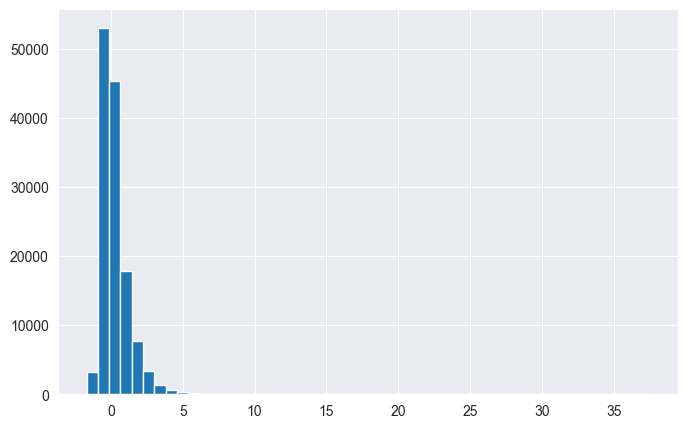

In [37]:
# Sample plot histogram to check standardized variable
X_temp.num_scaler__calculatedfinishedsquarefeet.hist(bins=50, figsize=(8,5))
plt.show()

## Correlation Sanity Check 

Prior to creating new features using the chosen subset of variables from the original dataset, it is important to perform a quick correlation analysis between the variables to drop any highly correlated variables that were missed in the earlier analysis

<Axes: >

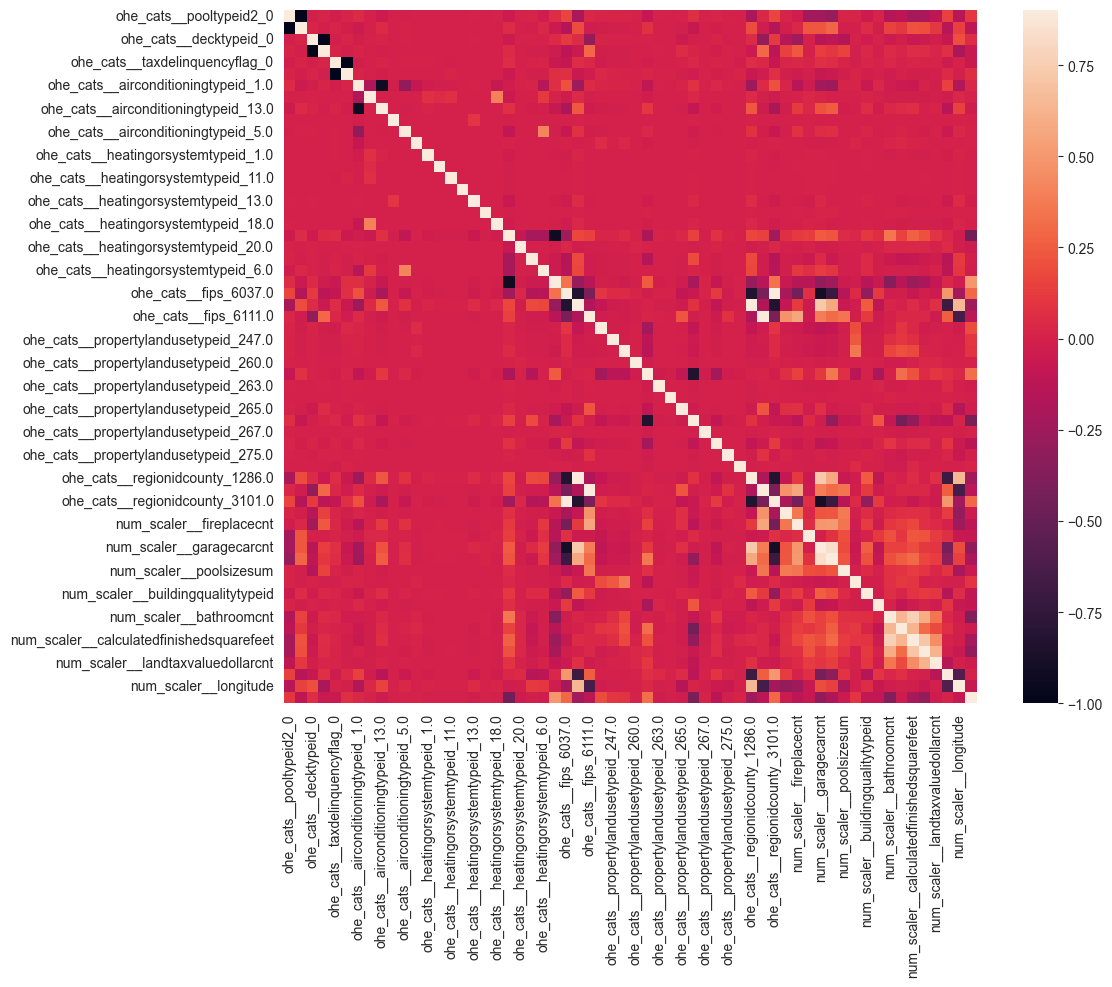

In [38]:
#Correlation map to see how features are correlated with SalePrice
corrmat = X_temp.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

`TaxAmount` is highly correlated with `structuretaxvaluedollarcnt` and `landtaxvaluedollarcnt` which makes sense given its the sum of the two variables. Thus, it is dropped from the analysis.

**Note**: After the initial exploratory analysis, the finding that `TaxAmount` is correlated with other variables and needs to be droppped was incorporated in `FeatureDropper` pipeline earlier to avoid repeated code later. 

Sample Code to drop variable: 
`df_train = df_train.drop("taxamount", axis=1)`

## Create Polynomial Features Pipeline

To better detect higher degree relations between the target variable and predictors, we'll find the most important features relative to the target and create 3 new polynomial variables for each of the top 8 existing features (out of the 15 numerical features). The three new polynomial features are: 
- `feature^2`
- `feature^3`
- `sqrt(feature)` 

This transformation is useful for models such as linear regression compared to more complex models such as Random Forest, GBMs that can detect non-linear patters within the data without such feature engineering.

In [40]:
# Find most important features relative to target (Take absolute value)
print("Find most important features relative to target")
corr_df = X_temp.copy()
corr_df["logerror"] = y_train.values
corr = corr_df.corr()
most_corr_feat = corr.logerror.abs().sort_values(ascending=False)[1:9].index
most_corr_feat

Find most important features relative to target


Index(['num_scaler__calculatedfinishedsquarefeet', 'num_scaler__bathroomcnt',
       'num_scaler__bedroomcnt', 'num_scaler__structuretaxvaluedollarcnt',
       'num_scaler__house_age', 'num_scaler__garagetotalsqft',
       'num_scaler__garagecarcnt', 'num_scaler__poolcnt'],
      dtype='object')

In [41]:
class CreatePolynomialFeatures(BaseEstimator, TransformerMixin):
    """
    Creates new polynomial features using the 10 most important features relative to the target. 
    3 new polynomial variables for each of the existing features: squared, cubed, sqrt. 
    """
    def __init__(self, most_imp_feat):
        self.most_imp_feat = most_imp_feat
    
    def fit(self, X, y=None):
        return self  # nothing else to do 
    
    def transform(self, X): 
        
        for var in self.most_imp_feat: 
            # New var names 
            s2_var_name = var + '-s2'
            s3_var_name = var + '-s3'
            sq_var_name = var + '-sqrt'
            
            # Create features 
            X[s2_var_name] = X[var] ** 2 
            X[s3_var_name] = X[var] ** 3 
            X[sq_var_name] = np.sqrt(X[var] + abs(min(X[var])))  # Translate feature to ensure min value is 0 before sqrt 
            
        return X
    
# Code to test pipeline
poly_feat_creator = CreatePolynomialFeatures(most_corr_feat)
X_temp = poly_feat_creator.fit_transform(X_temp)

## Skewed Features Pipeline
Next transformation is applied to numerical features that are highly skewed (all variables with skewness above the threshold value of 0.75). We will be performing the **Box Cox Transformation** using scipy function `boxcox1p`. 

More details on Box Cox Transformation can be found [here](https://onlinestatbook.com/2/transformations/box-cox.html) along with Scipy official documentation for `boxcox1p` [here](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.special.boxcox1p.html). 

In [42]:
# Code to detect any skewed features 
numeric_feats = X_temp.dtypes[X_temp.dtypes == 'float'].index
skewed_feats = X_temp[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_feats[:20]

num_scaler__calculatedfinishedsquarefeet-s3   277.954
num_scaler__unitcnt                           220.529
num_scaler__bathroomcnt-s3                    136.289
num_scaler__calculatedfinishedsquarefeet-s2   101.162
num_scaler__structuretaxvaluedollarcnt-s3      98.535
num_scaler__garagetotalsqft-s3                 98.294
num_scaler__garagecarcnt-s3                    79.236
num_scaler__structuretaxvaluedollarcnt-s2      55.398
num_scaler__bedroomcnt-s3                      43.116
num_scaler__lotsizesquarefeet                  26.835
num_scaler__garagetotalsqft-s2                 24.628
num_scaler__bathroomcnt-s2                     18.723
num_scaler__bedroomcnt-s2                      13.909
num_scaler__garagecarcnt-s2                    13.487
num_scaler__yardbuildingsqft17                 12.273
num_scaler__landtaxvaluedollarcnt              11.997
num_scaler__poolsizesum                        10.773
num_scaler__structuretaxvaluedollarcnt          8.162
num_scaler__house_age-s3    

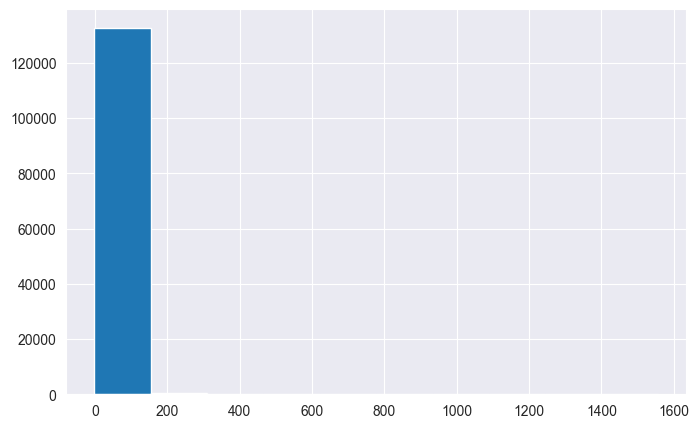

In [43]:
X_temp.num_scaler__lotsizesquarefeet.hist(bins=10, figsize=(8,5))
plt.show()

In [44]:
from datetime import date
from scipy.special import boxcox1p

class BoxCoxSkewedFeatures(BaseEstimator, TransformerMixin):
    """
    Performs Box-Cox tranformation on all numerical variables with skewness
    above a certain threshold. 
    """
    def __init__(self, skewness_thres=0.75):
        self.skewness_thres = skewness_thres
    def fit(self, X, y=None):
        return self  # nothing else to do 
    def transform(self, X): 
        numeric_feats = X.dtypes[X.dtypes == 'float'].index
        skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
        
        skewed_feats = skewed_feats[abs(skewed_feats) > self.skewness_thres].index
        
        # Apply box-cox to each variable 
        lam = 0.18
        for feat in skewed_feats:
            X[feat] = X[feat] + abs(min(X[feat]))       # Translate feature to ensure minimum value is 0 
            X[feat] = boxcox1p(X[feat], lam)
        return X
    

# # Code to test pipeline
skew_transformer = BoxCoxSkewedFeatures()
X_temp = skew_transformer.transform(X_temp)

In [45]:
# Check skewed features after box-cox transformation
numeric_feats = X_temp.dtypes[X_temp.dtypes == 'float'].index
skewed_feats = X_temp[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_feats[:20]

num_scaler__poolsizesum                       9.398
num_scaler__calculatedfinishedsquarefeet-s3   6.774
num_scaler__structuretaxvaluedollarcnt-s3     6.720
num_scaler__unitcnt                           6.238
num_scaler__yardbuildingsqft17                5.784
num_scaler__structuretaxvaluedollarcnt-s2     4.632
num_scaler__bathroomcnt-s3                    4.027
num_scaler__bedroomcnt-s2                     3.458
num_scaler__garagecarcnt-s3                   3.421
num_scaler__calculatedfinishedsquarefeet-s2   3.332
num_scaler__bedroomcnt-s3                     3.188
num_scaler__lotsizesquarefeet                 3.147
num_scaler__fireplacecnt                      3.005
num_scaler__bathroomcnt-s2                    2.476
num_scaler__structuretaxvaluedollarcnt        1.797
num_scaler__landtaxvaluedollarcnt             1.784
num_scaler__garagecarcnt-s2                   1.719
num_scaler__poolcnt-sqrt                      1.465
num_scaler__poolcnt-s3                        1.465
num_scaler__

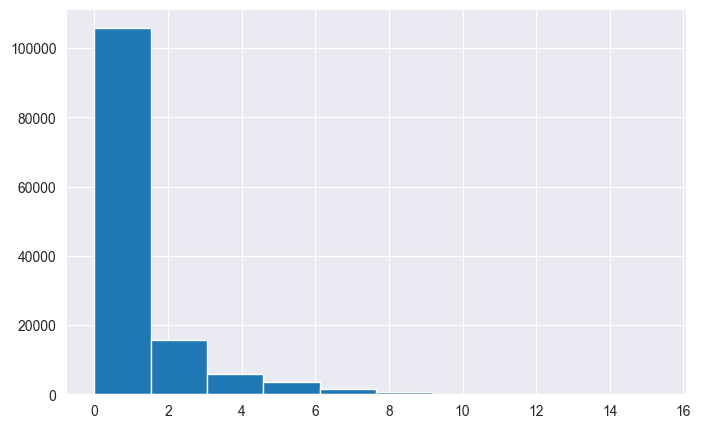

In [46]:
X_temp.num_scaler__lotsizesquarefeet.hist(bins=10, figsize=(8,5))
plt.show()

In [47]:
X_temp.head()

,ohe_cats__pooltypeid2_0,ohe_cats__pooltypeid2_1.0,ohe_cats__decktypeid_0,ohe_cats__decktypeid_66.0,ohe_cats__taxdelinquencyflag_0,ohe_cats__taxdelinquencyflag_Y,ohe_cats__airconditioningtypeid_1.0,ohe_cats__airconditioningtypeid_11.0,ohe_cats__airconditioningtypeid_13.0,ohe_cats__airconditioningtypeid_3.0,ohe_cats__airconditioningtypeid_5.0,ohe_cats__airconditioningtypeid_9.0,ohe_cats__heatingorsystemtypeid_1.0,ohe_cats__heatingorsystemtypeid_10.0,ohe_cats__heatingorsystemtypeid_11.0,ohe_cats__heatingorsystemtypeid_12.0,ohe_cats__heatingorsystemtypeid_13.0,ohe_cats__heatingorsystemtypeid_14.0,ohe_cats__heatingorsystemtypeid_18.0,ohe_cats__heatingorsystemtypeid_2.0,ohe_cats__heatingorsystemtypeid_20.0,ohe_cats__heatingorsystemtypeid_24.0,ohe_cats__heatingorsystemtypeid_6.0,ohe_cats__heatingorsystemtypeid_7.0,ohe_cats__fips_6037.0,ohe_cats__fips_6059.0,ohe_cats__fips_6111.0,ohe_cats__propertylandusetypeid_246.0,ohe_cats__propertylandusetypeid_247.0,ohe_cats__propertylandusetypeid_248.0,ohe_cats__propertylandusetypeid_260.0,ohe_cats__propertylandusetypeid_261.0,ohe_cats__propertylandusetypeid_263.0,ohe_cats__propertylandusetypeid_264.0,ohe_cats__propertylandusetypeid_265.0,ohe_cats__propertylandusetypeid_266.0,ohe_cats__propertylandusetypeid_267.0,ohe_cats__propertylandusetypeid_269.0,ohe_cats__propertylandusetypeid_275.0,ohe_cats__propertylandusetypeid_31.0,ohe_cats__regionidcounty_1286.0,ohe_cats__regionidcounty_2061.0,ohe_cats__regionidcounty_3101.0,num_scaler__yardbuildingsqft17,num_scaler__fireplacecnt,num_scaler__poolcnt,num_scaler__garagecarcnt,num_scaler__garagetotalsqft,num_scaler__poolsizesum,num_scaler__unitcnt,num_scaler__buildingqualitytypeid,num_scaler__lotsizesquarefeet,num_scaler__bathroomcnt,num_scaler__bedroomcnt,num_scaler__calculatedfinishedsquarefeet,num_scaler__structuretaxvaluedollarcnt,num_scaler__landtaxvaluedollarcnt,num_scaler__latitude,num_scaler__longitude,num_scaler__house_age,num_scaler__calculatedfinishedsquarefeet-s2,num_scaler__calculatedfinishedsquarefeet-s3,num_scaler__calculatedfinishedsquarefeet-sqrt,num_scaler__bathroomcnt-s2,num_scaler__bathroomcnt-s3,num_scaler__bathroomcnt-sqrt,num_scaler__bedroomcnt-s2,num_scaler__bedroomcnt-s3,num_scaler__bedroomcnt-sqrt,num_scaler__structuretaxvaluedollarcnt-s2,num_scaler__structuretaxvaluedollarcnt-s3,num_scaler__structuretaxvaluedollarcnt-sqrt,num_scaler__house_age-s2,num_scaler__house_age-s3,num_scaler__house_age-sqrt,num_scaler__garagetotalsqft-s2,num_scaler__garagetotalsqft-s3,num_scaler__garagetotalsqft-sqrt,num_scaler__garagecarcnt-s2,num_scaler__garagecarcnt-s3,num_scaler__garagecarcnt-sqrt,num_scaler__poolcnt-s2,num_scaler__poolcnt-s3,num_scaler__poolcnt-sqrt
0,1.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.114,0.568,1.215,0.000,1.094,0.421,0.240,-0.201,-0.120,-0.353,0.000,2.086,0.903,0.000,2.695,1.414,0.000,1.691,0.860,0.251,0.705,0.562,0.119,1.381,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,1.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.522,0.853,1.575,-0.500,1.319,1.089,0.322,0.192,-0.219,-1.059,0.288,2.129,0.999,0.738,2.853,1.732,0.228,1.653,0.738,0.387,0.945,0.901,0.805,0.893,0.542,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.738,0.000,0.000,

## Ordinal Encoding Categorical Variables 

This is done to categorical variables that may contain information in their ordering set. Unfortunately, there are no features in this dataset that require ordinal encoding. For any pipelines that require ordinal encoding, it is suggested to use `OrdinalEncoder` instead of `LabelEncoder` as they both perform the exact same operation however, `OrdinalEncoder` can handle multiple columns while `LabelEncoder` needs to be called on columns one at a time. 

In [48]:
# Clear memory
del X_temp; gc.collect()

11457

# Full Data Preparation Pipeline 

All the hardwork in creating the individual pipelines above can now be easily used by creating custom Pipelines as shown in cells below. This allows us to easily experiment with different preprocessing steps for different models.

In [49]:
X_prepared = X_train.copy()
X_prepared_val = X_val.copy()

In [50]:
# Feature Dropper Pipeline
feature_dropper = FeatureDropper(features_to_drop=lin_reg_drop_vars)

# Convert Date Features Pipeline
year_feat_creator = CreateYearFeatures(date_features=date_features)

# Feature Encoding and Scaling Pipeline
feature_encoder_scaler = FeatureEncoderAndScaler()

# Transform Skewed Numerical Features Pipeline
skew_transformer = BoxCoxSkewedFeatures()

# Two versions below: Univariate Imputation and Multivariate Imputation - ONLY UNCOMMENT ONE SECTION
########################################### 
# 1) Univariate Imputation Pipeline

convert_to_bool = ["pooltypeid2", "decktypeid", "taxdelinquencyflag"] 
convert_to_string= ["airconditioningtypeid", "heatingorsystemtypeid", "fips", "propertylandusetypeid", "regionidcounty"]
univariate_impute_pipe = ColumnTransformer([
        ("impute_0", SimpleImputer(strategy="constant", fill_value=0), impute_0_vars),
        ("impute_mode", SimpleImputer(strategy="most_frequent"), impute_mode_vars),
        ("impute_median", SimpleImputer(strategy="median"), impute_median_vars),
    ],
    remainder='passthrough'
)
col_name_appender = ColumnNamesAppender(univariate_impute_pipe, X_train.columns, num_transformers=3)
feature_type_changer = ConvertFeatureType(convert_to_int=convert_to_int, convert_to_string=convert_to_string, 
                                          convert_to_float=convert_to_float, convert_to_bool=convert_to_bool)
poly_feat_creator = CreatePolynomialFeatures(most_corr_feat)


############################################
# 2) Multivariate Version

# convert_to_string= ["airconditioningtypeid", "heatingorsystemtypeid", "fips", "propertylandusetypeid", "regionidcounty", "pooltypeid2", "decktypeid", "taxdelinquencyflag"]
# multivariate_impute_pipe = ColumnTransformer([
#         ("impute_cats", SimpleImputer(strategy="constant", fill_value='missing'), cat_impute_vars),
#         ("impute_num", IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, max_depth=30, min_samples_leaf=32), random_state=0, max_iter=1), numeric_impute_vars),
#     ],
#     remainder='passthrough'
# )
# col_name_appender = ColumnNamesAppender(multivariate_impute_pipe, X_train.columns, num_transformers=3)
# feature_type_changer = ConvertFeatureType(convert_to_int=convert_to_int, convert_to_string=convert_to_string, convert_to_float=convert_to_float)
# # most_corr_feat = list(map(lambda x: x.replace('num_scaler__',''), most_corr_feat))     # Clean up feature names by removing `num_scaler__`
# poly_feat_creator = CreatePolynomialFeatures(most_corr_feat)


In [51]:
lin_reg_preprocessor = Pipeline([
        ('feature_dropper', feature_dropper),
        ('univariate_impute_pipe', univariate_impute_pipe),
#         ('multivariate_impute_pipe', multivariate_impute_pipe),
        ('col_name_appender', col_name_appender),
        ('feature_type_changer', feature_type_changer),
        ('year_feat_creator', year_feat_creator),
        ('feature_encoder_scaler', feature_encoder_scaler),
        ('poly_feat_creator', poly_feat_creator),
        ('skew_transformer', skew_transformer),
    ])

data_prep_pipe = lin_reg_preprocessor.fit(X_prepared)
X_prepared = lin_reg_preprocessor.transform(X_prepared)
X_prepared_val = lin_reg_preprocessor.transform(X_prepared_val)

In [52]:
from sklearn import set_config
set_config(display='diagram')
lin_reg_preprocessor

,steps,"[('feature_dropper', ...), ('univariate_impute_pipe', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,features_to_drop,"['finishedsquarefeet13', 'finishedsquarefeet15', ...]"
,transformers,"[('impute_0', ...), ('impute_mode', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


# Select and Train Models

**As this project is primarily for learning purposes, candidate machine learning algorithms will be analyzed in greater detail before being rejected to better understand the algorithms for future usage.**


In [53]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

In [54]:
lin_reg = LinearRegression()
lin_reg.fit(X_prepared, y_train)

# let's try the full preprocessing pipeline on a few training instances
some_data = X_train.iloc[:5]
some_labels = y_train.iloc[:5]
some_data_prepared = data_prep_pipe.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [0.08368088803691051 -0.07879256206156901 -0.08983706717790454
 -0.037484877962342955 -0.07954348870825631]
Labels: [-0.104536755154, 0.036743366071, -0.0136873002723, -0.106598394839, -0.0325]


## Model Evaluation 

### Baseline Metrics 

It is important to set a baseline for the model's performance to compare different algorithms. For regression problems, the baseline metrics are calculated by replacing $y'$ with $\bar{y}$. Using this, the different baseline regression metrics are: 

- **MSE Baseline**: Variance of the target variable
- **RMSE Baseline**: Standard Deviation of the target variable
- **MAE Baseline**: Average Abolsute Deviation of the target variable
- **R2 Baseline**: 0

For this regression problem, we will use the models' **Mean Absolute Error** and **RMSE (Root Mean Squared Error)** to compare the different algorithms which have **baseline values of 0.533 and 0.0837** respectively.

We will also observe the RMSE as another evaluation metric which punishes more for outliers than MAE. 

In [58]:
# Baseline for RMSE
print(f"MAE Baseline: {y_train.abs().mean()}")  # Use abs().mean() instead of mad()
print(f"RMSE Baseline: {y_train.std()}")

MAE Baseline: 0.05363425706164631
RMSE Baseline: 0.08371665588521533


### MAE Evaluation 

To evaluate and short list the most promising models, we will use the models' **MAE** in two different ways: 

1) **MAE on Validation Set**: Calculates the MAE on the validation set which is quicker to calculate than evaluation using Cross-Validation. However, it is possible the MAE obtained is skewed depending on the instances sampled in the validation set. 

2) A great alternative is to use **K-Fold Cross-Validation** where the training set is randomly split into `n` subsets (for example 10 subsets) called *folds*. It trains and evaluates the model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. Result is an array containing the 10 evaluation scores. Takes longer to evaluate but provides a more accurate measure of the model's performance.



In [62]:
def get_eval_metrics(models, X, y_true): 
    """
    Calculates MAE (Mean Absoulate Error) and RMSE (Root Mean Squared Error) on the data set for input models. 
    `models`: list of fit models 
    """
    for model in models: 
        y_pred= model.predict(X)
        rmse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        print(f"Model: {model}")
        print(f"MAE: {mae}, RMSE: {rmse}")

# Test usage of RMSE function
# get_eval_metrics([lin_reg, ridge_reg, lasso_reg], X_prepared_val, y_val)

In [64]:
def display_scores(model, scores):
    print("-"*50)
    print("Model:", model)
    print("\nScores:", scores)
    print("\nMean:", scores.mean())
    print("\nStandard deviation:", scores.std())
    
def get_cross_val_scores(models, X, y, cv=10, fit_params=None):
    """
    Performs k-fold cross validation and calculates MAE for each fold for all input models. 
    `models`: list of fit models 
    """    
    for model in models: 
        mae = -cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=cv)
        display_scores(model, mae) 

# Test usage of cross val function
# get_cross_val_scores([lin_reg, ridge_reg], X_prepared, y_train, cv=5)

## Train Multiple Models 

Now that we've tested our data preparation pipeline with a sample model, the next step is to train the data on different regression algorithms to shortlist the most promising algorithms for our problem. 

Algorithms to test with include: 
- **Multiple Linear Regression**: Simple algorithm to implement but can over-simplify real-world problems by assuming a linear relationship among the variables. 
- **Linear Regression with Regularization (Lasso, Ridge, ElasticNet)**: Techniques that penalize the linear regression model to prevent overfitting.
- **Support Vector Regression**: Uses hyperplanes to segregate the data. 
- **Decision Tree**: Powerful model capable of finding complex nonlinear relationships in the data.
- **Random Forest**: Train many Decision Tress on random subsets of the features (*Ensemble Learning*).
- **Gradient Boosting Machines**: Powerful and versatile algorithms (mostly using trees) that sequentially train weak learners to improve after each training iteration. 
- **Stacking Models**: Stacking involves training a new learning algorithm to combine the predictions of several base learners

# 1. Linear Regression Models 

Both plain Linear Regression and Regularized Linear Regression algorithms will be tested. 
Both **Simple Multiple Linear Regression** and **Regularized Linear Regression (Ridge, Lasso, ElasticNet)** will be analyzed. Specifically, the algorithms tested are: 

- **Simple Multiple Linear Regression**: Plain linear regression that minimizes the Mean Squared Error(MSE) cost function. 

### Regularized Models
A good way to reduce overfitting is to regularize the model (i.e. to constrain it): the fewer degrees of freedom it has, the harder it will be for it to overfit the data. For a linear model, regularization is typically acheived by constraining the weights of the model - this forced the learning algorithm to not only fit the data but also keep the model weights as small as possible. 
- **Ridge Regression (L2 norm)**: A regularization term equal to $\alpha*\Theta_{j}^2$ is added to the cost function where $\Theta_{j}$ are the model weights and $\alpha$ is a hyperparameter that controls how much the model is regularized. 
    - If $\alpha=0$, then Ridge Regression is just Simple Linear Regression. If $\alpha$ is very large, then all weights end up very close to zero (**but NOT zero**) and the result is a flat line going through the data's mean.
- **Lasso Regression (L1 norm)**: A regularization term equal to $\alpha*\lvert \Theta_{j} \rvert$ is added to the cost function where $\Theta_{j}$ are the model weights and $\alpha$ is a hyperparameter that controls how much the model is regularized. 
    - Lasso Regression tends to eliminate the weights of the least important features (i.e. set them to zero). In other words, Lasso Regression automatically performs feature selection and outputs a sparse model with few nonzero feature weights. 
- **ElasticNet Regression (L1 and L2 norm)**: Elastic Net is a middle ground between Ridge Regression and Lasso Regression. The regularization term is a simple mix of both Ridge and Lasso's regularization terms, and you can control the mix ratio $r$. 
    - When $r=0$, Elastic Net is equivalent to Ridge Regression, and when $r=1$, it is equivalent to Lasso Regression. 

### Which Model to Use When?

- **Simple Linear Regression**: It is almost always preferable to have at least a bit of regularization, so generally you should avoid plain Linear Regression. 
- **Ridge Regression**: Ridge is a good default when most features are useful, but if you suspect that only a few features are useful, you should prefer Lasso or Elastic Net because they can exclude the useless features from the equations (Ridge never makes the weights zero, can only be very close to zero). 
- **Elastic-Net / Lasso**: In general, Elastic Net is preferred over Lasso because Lasso may behave erratically when the number of features is greater than the number of training instances or when several features are strongly correalted. 
    - Especially good at dealing with situations when there are correlations between parameters as **Elastic Net groups and shrinks associated with the correlated variables and leaves them in equation or removes them all at once.**

Cross Validation is used to find the optimal values for each of the Ridge and Lasso parameters ($\alpha_{1}, \alpha_{2}$). 

## 1a) Simple Linear Regression

**Things of note:**
- The model RMSE is significantly higher than MAE which suggests that the outliers are affecting the model's performance as RMSE punishes the model more for mispredicting outliers. 
- The K-Fold Cross Validation shows that the model's performance is highly volatile

In [65]:
# Linear Regression 
lin_reg = LinearRegression()
lin_reg.fit(X_prepared, y_train)

get_eval_metrics([lin_reg], X_prepared_val, y_val)
get_cross_val_scores([lin_reg], X_prepared, y_train, cv=5)

Model: LinearRegression()
MAE: 0.052988488079252355, RMSE: 0.006990853060825626
--------------------------------------------------
Model: LinearRegression()

Scores: [0.05349129 0.05344454 0.05250397 0.05332724 0.05303071]

Mean: 0.05315955090696526

Standard deviation: 0.0003649038848350267


### Learning Curves 

To detect where the model is under or overfitting, we can look at the *learning curves*. **Learning Curves** are plots of the model’s performance on the training set and the validation set as a function of the training set size (or the training iteration). To generate the plots, train the model several times on different sized subsets of the training set.
 

In [66]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X_train, y_train, X_val, y_val):
    """
    Train the input model on different sized subsets and test on validation set. 
    Output a plot of training and validation error for the different sized subsets. 
    """
    train_errors, val_errors = [], []
    num_instances = np.linspace(1, len(X_train), num=15).astype(int)
    
    for m in num_instances:
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_absolute_error(y_train[:m], y_train_predict))
        val_errors.append(mean_absolute_error(y_val, y_val_predict))
    plt.plot(num_instances, train_errors, "r-+", linewidth=2, label="train")
    plt.plot(num_instances, val_errors, "b-", linewidth=3, label="val")
    plt.legend(loc='best')
    plt.title(model)
    return plt

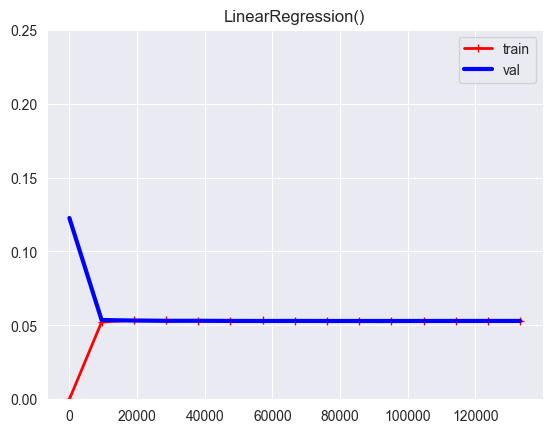

In [67]:
lin_reg = LinearRegression()
plt = plot_learning_curves(lin_reg, X_prepared, y_train, X_prepared_val, y_val)
plt.ylim(0, 0.25) 
plt.show()

### Learning Curve Conclusion for Linear Regression 

- `train` curve starts with really low RMSE due to the model overfitting on the small number of instances. Conversely, `val` curve (highest value cut off) starts with an extremely high RMSE which is expected since the model is overfit on the small number of training instances. 
- The Linear Regression model is underfitting as increasing the number of instances does not improve the model's performance much on either dataset. 
- Furthermore, the model is not overfitting as the MAE error observed for both the validation and training sets is extremely close (errors would be different between `train` and `val` datasets if the model were overfitting with the `train` dataset, thus showing lower MAE values.  

**As expected, Simple Linear Regression is unable to handle the intricacies of the training data and thus is a high bias model which is underfitting.**

## 1b) Ridge and Lasso Regression 

- **Ridge Regression (L2 norm)**: A regularization term equal to $\alpha*\Theta_{j}^2$ is added to the cost function where $\Theta_{j}$ are the model weights and $\alpha$ is a hyperparameter that controls how much the model is regularized. 
- **Lasso Regression (L1 norm)**: A regularization term equal to $\alpha*\lvert \Theta_{j} \rvert$ is added to the cost function where $\Theta_{j}$ are the model weights and $\alpha$ is a hyperparameter that controls how much the model is regularized. 

Since the Ridge and Lasso models' performance is highly affected by the chosen `alpha` value, we need to tune its value to find the optimal `alpha` for the given problem. 

**NOTE**: **In this case, any of the Regularized Linear Models will NOT perform any better than the Simple Linear Regression. Regularized models help reduce overfitting and we have already established that our current Linear Model is underfitting. Thus, the following models are being explored merely for LEARNING purposes.**

In [68]:
# Set of alpha values to test
alphas = np.logspace(0,2,20)
print(f"Testing with alphas={alphas}")

# Tune Ridge Regression
ridgecv = RidgeCV(alphas=alphas)
ridgecv.fit(X_prepared, y_train)
print(f"Best Ridge Alpha: {ridgecv.alpha_}")

Testing with alphas=[  1.           1.27427499   1.62377674   2.06913808   2.6366509
   3.35981829   4.2813324    5.45559478   6.95192796   8.8586679
  11.28837892  14.38449888  18.32980711  23.35721469  29.76351442
  37.92690191  48.32930239  61.58482111  78.47599704 100.        ]
Best Ridge Alpha: 48.32930238571752


In [69]:
# Set of alpha values to test
alphas = np.logspace(1,5,20)
print(f"Testing with alphas={alphas}")

# Tune Lasso Regression
lassocv = LassoCV(alphas=alphas)
lassocv.fit(X_prepared, y_train)
print(f"Best Lasso Alpha: {lassocv.alpha_}")

Testing with alphas=[1.00000000e+01 1.62377674e+01 2.63665090e+01 4.28133240e+01
 6.95192796e+01 1.12883789e+02 1.83298071e+02 2.97635144e+02
 4.83293024e+02 7.84759970e+02 1.27427499e+03 2.06913808e+03
 3.35981829e+03 5.45559478e+03 8.85866790e+03 1.43844989e+04
 2.33572147e+04 3.79269019e+04 6.15848211e+04 1.00000000e+05]
Best Lasso Alpha: 100000.0


**The extremely high value of `alpha` for Lasso regression above will regularize the model heavily and push coefficients to zero.**

In [70]:
# Fit using optimal alpha
ridge = Ridge(alpha=ridgecv.alpha_)
ridge.fit(X_prepared, y_train)

lasso = Lasso(alpha=lassocv.alpha_)
lasso.fit(X_prepared, y_train)

# get_eval_metrics([ridge, lasso], X_prepared_val, y_val)
get_cross_val_scores([ridge, lasso], X_prepared, y_train, cv=5)

--------------------------------------------------
Model: Ridge(alpha=np.float64(48.32930238571752))

Scores: [0.05348823 0.05344475 0.05250575 0.05331932 0.05304003]

Mean: 0.053159615354047604

Standard deviation: 0.0003623920460873151
--------------------------------------------------
Model: Lasso(alpha=np.float64(100000.0))

Scores: [0.05364104 0.05366448 0.0527301  0.0535848  0.05326353]

Mean: 0.05337678920628811

Standard deviation: 0.0003540889031593196


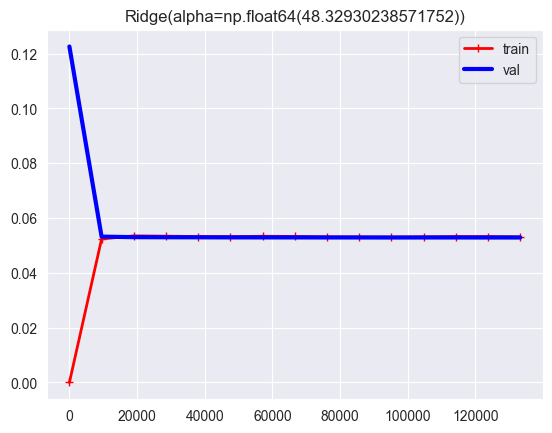

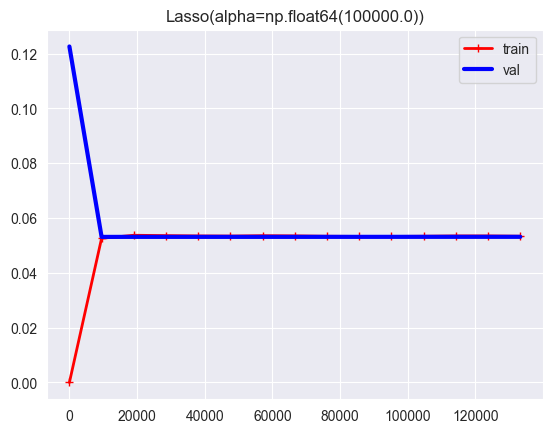

In [71]:
# Learning Curves for Ridge and Lasso
ridge = Ridge(alpha=ridgecv.alpha_)
plt = plot_learning_curves(ridge, X_prepared, y_train, X_prepared_val, y_val)
plt.show()

lasso = Lasso(alpha=lassocv.alpha_)
plt = plot_learning_curves(lasso, X_prepared, y_train, X_prepared_val, y_val)
plt.show()

**As expected, even the regularized Linear Models do not perform any better. Thus, we need to consider more complex algorithms which make fewer assumptions to try and understand the relationship between the features and target variable.** 

# 2) Decision Trees & Random Forest Models

Next, we'll consider the use of tree-based algorithms. Two of the popular tree-based algorithms are: 
- **Decision Tree**: Powerful model capable of finding complex nonlinear relationships in the data.
- **Random Forest**: Train many Decision Tress on random subsets of the features via the bagging method (Ensemble Learning).
 
To save time, `DecisionTreeRegressor` will be skipped as a candidate due to its tendency to easily overfit and yield a model with high variance despite low bias. **Instead, `RandomForestRegressor` is a better option as it is an ensemble of Decision Trees, generally trained via the bagging method (sampling the dataset with replacement).** 

**Random Forest introduces extra randomness when growing trees by searching for the best feature among a *random subset of features* instead of *the very best feature at every node*. 
This yields in greater tree diversity, which trades a higher bias for a lower variance, generally resulting in a better overall model.**

In [72]:
X_prepared = X_train.copy()
X_prepared_val = X_val.copy()

In [73]:
# Feature Dropper Pipeline
rf_drop_vars = ['parcelid']
feature_dropper = FeatureDropper(features_to_drop=rf_drop_vars)

# Create Date Features
date_feat_creator = CreateDateFeatures()
final_column_names = list(X_train.columns) + ['transaction_year', 'transaction_month', 'transaction_day', 'transaction_quarter']

# Univariate Impute Pipeline
rf_impute_median_vars = [
    "lotsizesquarefeet", "bathroomcnt", "bedroomcnt", "calculatedfinishedsquarefeet", "structuretaxvaluedollarcnt", 
    "landtaxvaluedollarcnt", "latitude", "longitude", "finishedsquarefeet13", "finishedsquarefeet15", 
    "finishedfloor1squarefeet", "finishedsquarefeet50", "finishedsquarefeet6", "threequarterbathnbr", 
    "calculatedbathnbr", "fullbathcnt", "numberofstories", "finishedsquarefeet12", "taxvaluedollarcnt", 
    "taxamount", "roomcnt", "basementsqft", "yardbuildingsqft26", "unitcnt"
]
rf_impute_0_vars = ["yardbuildingsqft17", "fireplacecnt", "poolcnt", "garagecarcnt", "garagetotalsqft", "poolsizesum"]
rf_cat_vars = [
    'airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 'buildingqualitytypeid', 
    'decktypeid', 'fips',  'hashottuborspa', 'heatingorsystemtypeid',  'pooltypeid10', 'pooltypeid2', 
    'pooltypeid7', 'propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc', 
    'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 
    'storytypeid',  'typeconstructiontypeid', 'fireplaceflag',  'assessmentyear', 
    'taxdelinquencyflag', 'taxdelinquencyyear', 'censustractandblock', 'yearbuilt',
    'transaction_year', 'transaction_month', 'transaction_day', 'transaction_quarter',
]

univariate_impute_pipe = ColumnTransformer([
    ("rf_impute_cats", SimpleImputer(strategy="constant", fill_value="missing"), rf_cat_vars),
    ("rf_impute_0_vars", SimpleImputer(strategy="constant", fill_value=0), rf_impute_0_vars),
    ("rf_impute_median", SimpleImputer(strategy="median"), rf_impute_median_vars),
],
    remainder='passthrough'
)

# Column Names Appender 
col_name_appender = ColumnNamesAppender(univariate_impute_pipe, final_column_names, num_transformers=3)

# Convert to Cat + One-Hot Encoding
convert_to_cat = ConvertToType(var_type='str', vars_to_convert=rf_cat_vars)
feature_encoder = ColumnTransformer([
    ("ohe_cats", OneHotEncoder(handle_unknown='ignore'), rf_cat_vars)
],
    remainder='passthrough'
)

In [74]:
rf_preprocessor = Pipeline([
    ('date_feat_creator', date_feat_creator),
    ('feature_dropper', feature_dropper),
    ('univariate_impute_pipe', univariate_impute_pipe),
    ('col_name_appender', col_name_appender),
    ('convert_to_cat', convert_to_cat),
    ('feature_encoder', feature_encoder),
])

data_prep_pipe = rf_preprocessor.fit(X_prepared)
X_prepared = rf_preprocessor.transform(X_prepared)
X_prepared_val = rf_preprocessor.transform(X_prepared_val)

In [75]:
X_rf = X_prepared.copy()
X_rf_val = X_prepared_val.copy()

## Hyperparameter Tuning

For random forests and tree-based models in general, overfitting on the training set happens very easily given the very few assumptions Decision Trees make about the training data. Thus, such models are often called a **non-parametric model** because the number of parameters is not determined prior to training, so the model structure is free to stick closely to the data. In contrast, a **parametric model**, such as a linear model, has a predetermined number of parameters, limiting its degrees of freedome and reducing the risk of overfiting. 

Thus, to avoid overfitting the training data, we will be looking at the following hyperparameters: 

- ``max_depth``: To restrict the maximum number of levels of the Decision Tree (unlimited depth by default). 
- ``max_features``: Number of features to consider at every split (default is all features)
- ``min_samples_split``: The minimum number of samples a node must have before it can be split (2 by default)
- ``min_samples_leaf``: The minimum number of samples a leaf node must have (1 by default)

**Increasing ``min_*`` hyperparameters or reducing ``max_*`` hyperparameters will regularize the model.**

To reduce the overall runtime of training a random forest, we will be looking at the following hyperparameters: 
- ``max_samples``: Fraction of original dataset given to any individual tree. Given the massive training dataset in our case, the full dataset is overkill when training each tree (default is full dataset).
- ``n_estimators``: Number of trees in random forest (default=100)

### Guide to Tuning Random Forests

We will follow the following strategy to tune random forest given the high training time due to large sample size. Luckily, Random Forests perform fairly well out of the box and do not require a large amount of hyperparameter tuning unlike XGBoost for example. 

1. Use the default ``n_estimators`` and low ``max_samples`` until all other hyperparamters are tuned. 
    - This helps reduce the model training time until the final step at which point both hyperparameters can be increased to test any performance improvement. 
    - For this problem, we'll be using the default ``n_estimators`` (100) and ``max_samples=0.1`` i.e. 10 per cent of the data samples given the extremely large data size. 
2. Focus on tuning ``max_depth`` and ``max_features`` 
   - ``max_depth`` helps regularize the model to prevent overfitting and ``max_features`` leads to trees that are more random by picking a random subset of features at every split.
3. Finally, briefly tune ``min_samples_split`` or ``min_samples_leaf`` which can provide a minor boost in performance through greater regularization
4. After tuning the hyperparameters in steps 2 and 3, test increasing both ``n_estimators`` and ``max_samples`` to find values at which the model performance plateaus. 

### Random Search + Grid Search Results 

Below are the results from using Random Search in combination with Grid Search to arrive at the optimized hyperparameters. Sample code for each method is shown in cells below. 

1) ``Random Search with max_samples=0.1``

        Random Grid with 20 different combinations = 
        'max_depth': [5, 16, 27, 38, 50, None],
        'max_features': ['auto', 0.6, 0.7, 0.8],
        'min_samples_leaf': [32, 64, 128, 256],
        
        Best Params = 
        {'max_depth': 50,
         'max_features': 0.6,
         'min_samples_leaf': 32,}

2) ``Grid Search with max_samples=0.1``

        Grid = 
        {'max_features': ['auto', 0.5, 0.6, 0.8, 0.9],
         'max_depth': [10, 40, 70, 100, None],
         'min_samples_leaf': [16, 32, 64],}

        Best Params: 
        {'max_depth': 70,
         'max_features': 0.6,
         'min_samples_leaf': 32,}

3) ``Final Grid Search``: Tune ``n_estimators`` and ``max_samples``

        Grid = 
        {'max_features': [0.6],
         'max_depth': [70],
         'min_samples_leaf': [32]
         'max_samples': [0.1, 0.3, 0.5],
         'n_estimators': [100, 400, 600]}

        Best Params: 
        {'n_estimators': 400,
         'max_samples': 0.3,
         'max_depth': 70,
         'max_features': 0.6,
         'min_samples_leaf': 32,}
         
**Given that Randon Forest are already great out-of-the-box and the increasingly long training times, there is no benefit in further optimizing the hyperparameters for the Random Forest Regressor.**

In [76]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Fraction of original dataset given to any individual tree
max_samples = [0.1, 0.2]
# Number of features to consider at every split
max_features = ['auto', 0.4, 0.6, 0.8, 0.9]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(50, 100, num = 4)]
# max_depth.append(None)
# Minimum number of samples required at each leaf node
min_samples_leaf = [16, 32, 48]

# Create the tuning grid
param_grid = {
    'max_samples': max_samples,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
}

In [77]:
###### Random Grid Sample Code #######
# Use the random grid to narrow down best hyperparameters

# First create the base model to tune
rf = RandomForestRegressor(max_samples=0.1)

# Random search of parameters, using 3 fold cross validation, 
# search across 20 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=20, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(X_prepared, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END max_depth=50, max_features=auto, max_samples=0.2, min_samples_leaf=32; total time=   0.1s
[CV] END max_depth=50, max_features=auto, max_samples=0.2, min_samples_leaf=32; total time=   0.1s
[CV] END max_depth=50, max_features=auto, max_samples=0.2, min_samples_leaf=32; total time=   0.1s
[CV] END max_depth=66, max_features=0.6, max_samples=0.1, min_samples_leaf=48; total time= 3.2min
[CV] END max_depth=83, max_features=auto, max_samples=0.2, min_samples_leaf=32; total time=   0.0s
[CV] END max_depth=83, max_features=auto, max_samples=0.2, min_samples_leaf=32; total time=   0.0s
[CV] END max_depth=66, max_features=0.6, max_samples=0.1, min_samples_leaf=48; total time= 3.2min
[CV] END max_depth=83, max_features=auto, max_samples=0.2, min_samples_leaf=32; total time=   0.0s
[CV] END max_depth=66, max_features=0.6, max_samples=0.1, min_samples_leaf=48; total time= 3.3min
[CV] END max_depth=50, max_features=0.9, max_sample

,estimator,RandomForestR...x_samples=0.1)
,param_distributions,"{'max_depth': [50, 66, ...], 'max_features': ['auto', 0.4, ...], 'max_samples': [0.1, 0.2], 'min_samples_leaf': [16, 32, ...]}"
,n_iter,20
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [86]:
###### Grid Search Sample Code #######
# Use the Grid search to further narrown down best hyperparameters

# First create the base model to tune
rf = RandomForestRegressor()
max_features = [0.4]
param_grid = {
    'max_features': max_features,
    'max_samples': [0.1]
}

# Grid search of parameters, using 3 fold cross validation
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2)

# Fit the random search model
rf_grid.fit(X_prepared, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


KeyboardInterrupt: 

In [88]:
# Output the best estimator from grid search and it's hyperparameters 
best_rf = rf_random.best_estimator_
best_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 83,
 'max_features': 0.9,
 'max_leaf_nodes': None,
 'max_samples': 0.2,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 32,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Final Random Forest Model

Based on the iterative hyperparameter tuning earlier, the following Random Forest Regressor is the optimized model. Furthermore, Random Forests have a great quality to measure the relative importance of each feature which is discussed in greater detail in the **Model Interpretability** section later in the notebook. 

In [343]:
# BEWARE: With high max_samples and 400 n_estimators, this code takes almost hour to run
best_params = {
    'n_estimators': 400,
    'max_samples': 0.3,
    'max_depth': 70,
    'max_features': 0.6,
    'min_samples_leaf': 32,    
    'random_state': 42, 
}

ran_forest = RandomForestRegressor(**best_params)
ran_forest.fit(X_prepared, y_train)

get_eval_metrics([ran_forest], X_prepared_val, y_val)
# get_cross_val_scores([ran_forest], X_prepared, y_train, cv=3)

Model: RandomForestRegressor(max_depth=70, max_features=0.6, max_samples=0.3,
                      min_samples_leaf=32, n_estimators=400, random_state=42)
MAE: 0.05121221532502788, RMSE: 0.08174075455406744


## Extra Trees Regressor
 
Random Forest searches for the best possible threholds when splitting at each node. However, it is possible to make trees even more random by also using random thresholds for each feature instead of best possible threshold. 

**A forest of such extremely random trees is called an Extremely Randomized Trees ensemble (or ``Extra-Trees``). This technique trades more bias for a lower variance and also makes Extra-Trees faster to train than regular Random Forests, because finding the best possible threshold for each feature at every node is one of the most time-consuming tasks.**

In this case, `Extra-Trees` did not perform much better than `Random Forest` and the only way to know which one is better for any problem is to test both algorithms. 

In [90]:
# WARNING: With high max_samples and high n_estimators, this code takes almost 2 hours to run
from sklearn.ensemble import ExtraTreesRegressor

# Using the best parameters from Random Forest Regressor
best_params = {
    'n_estimators': 100,
    'max_samples': 0.3,
    'max_depth': 70,
    'max_features': 0.6,
    'min_samples_leaf': 32,    
    'random_state': 42, 
}

extra_trees_reg = ExtraTreesRegressor(**best_params, bootstrap=True)
extra_trees_reg.fit(X_prepared, y_train)
# get_cross_val_scores([extra_trees_reg], X_prepared, y_train, cv=3)

KeyboardInterrupt: 

# 3) Support Vector Machines (SVM)

The next algorithm to consider is Support Vector Machines which can be used for both classification and regression problems. 

In a classification problem, the objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points. Conversely, in a regression problem, the objective is reversed: trying to find a hyperplane that fits as many instances as possible while limiting margin violations. 
### SVM Advantages
 
- Very versatile technique with linear and various non-linear kernels 
- Prediction is a SMOOTHLY varying function of the features unlike tree-based algorithms that are step-wise
- Works best on small to medium-sized datasets and even effective in cases where number of features is greater than the number of samples.

### SVM Disadvantages 

**Despite the advantages highlighted earlier, SVM is not a good choice for this Zillow Regression problem because:**
- SVM's training time increases non-linearly with the number of instances with a time complexity of $O(m^2*n)$ to $O(m^3* n)$ where `m` is the number of instances and `n` is the number of features. This is because SVMs have to estimate at least one parameter for each row in the training data! 
- **Given that the Zillow training data is more than 1e5 points, the training time is extremely long and the results of the base model are much worse than other tested models. Even if there is scope of improvement with hyperparameter tuning through grid search, the amount of training time is unjustified.** 

Sample code for the base SVM models with the different tested kernels is available in cells before for reference. 

In [ ]:
# Linear SVM Regression 
# Trains extremely quickly but not useful as the Zillow dataset is not linearly separable
from sklearn.svm import LinearSVR

svm_reg_linear = LinearSVR(random_state=42)
svm_reg_linear.fit(X_prepared, y_train)

In [ ]:
# SVM with Polynomial Kernel - 'transforms' data points to polynomial space using 'kernel trick'
from sklearn.svm import SVR
svm_poly_reg = SVR(kernel="poly")
svm_poly_reg.fit(X_prepared, y_train)

# SVM with Radial Basis Function (RBF) Kernel 
rbf_svm = SVR(kernel = 'rbf')
rbf_svm.fit(X_prepared, y_train)

In [ ]:
get_eval_metrics([svm_reg_linear, svm_poly_reg, rbf_svm], X_prepared_val, y_val)

# 4) Gradient Boosting Machines

The final model we'll be exploring is Gradient Boosting Machines (GBMs) which are extremely powerful algorithms for both regression and classification problems. 

**Whereas random forests build an ensemble of deep independent trees, GBMs build an ensemble of shallow trees in sequence with each tree learning and improving on the previous one. Although shallow trees by themselves are rather weak predictive models, they can be “boosted” to produce a powerful “committee” that, when appropriately tuned, is often hard to beat with other algorithms.**

In this section, we will be working with a few different implementations of Gradient Boost: 
- **XGBoost**: Stands for "eXtreme Gradient Boosting" and came out in 2015. It implemented a number of theoretical and practical improvements, many of which have become standard in subsequent packages. 
- **LightGBM**: Written by researchers at Microsoft Research and released in 2017. Major advances included smarter techniques (by default) to avoid searching all splits and speeding things up along with other improvements in handling categorical variables. 
- **CatBoost**: Written by group of researchers at Yandex and its major advance was allowing native handling of categorical variables (as strings) by doing on-the-fly numerical encoding of categorical variables, with a clever encoding scheme to reduce overfitting. 


### Gradient Boosting vs Random Forest
- Typically, Gradient Boosting can outperform Random Forests by a small, but not insignificant amount.
- However, Gradient Boosting requires much more "parameter tuning" to get the best performance
- For Random Forest, can usually use 1K or 2K trees and do well.  The only "major" parameter is the `max_features` and the default is usually reasonable.
- For Gradient Boosting, parameter tuning is considerably more complicated.

# 4-a) XGBoost 

Even though Scikit-Learn has its own implementation of Gradient Boost, it lacks in both performance and speed compared to other implementations. Thus, we will skip Scikit-Learn's implementation in favor of XGBoost, LightGBM, CatBoost.

### Missing Data

One of most powerful capabilities of Gradient Boosting machines is their ability to handle missing data. They do not require data imputation and are designed to extract as much information as possible from the rows with missing data. 

In [91]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

In [92]:
X_prepared = X_train.copy()
X_prepared_val = X_val.copy()

In [93]:
# Data Prep for XGBoost with Original Data 

# Feature Dropper Pipeline
xgb_drop = ['parcelid']
feature_dropper = FeatureDropper(features_to_drop=xgb_drop)

# Convert Year Features Pipeline
year_feat_creator = CreateYearFeatures(date_features=date_features)

# Date Feature Creator
date_feat_creator = CreateDateFeatures()

# Feature Encoding Pipeline
cat_vars = ['transaction_year', 'transaction_month', 'transaction_day', 'transaction_quarter', 
            'airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 'buildingqualitytypeid', 
            'decktypeid', 'fips',  'hashottuborspa', 'heatingorsystemtypeid',  'pooltypeid10', 'pooltypeid2', 
            'pooltypeid7', 'propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc', 
            'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 
            'storytypeid',  'typeconstructiontypeid', 'fireplaceflag',  'assessmentyear', 
            'taxdelinquencyflag', 'taxdelinquencyyear', 'censustractandblock',
           ]
feature_encoder = ColumnTransformer([
    ("ohe_cats", OneHotEncoder(handle_unknown='ignore'), cat_vars)
],
    remainder='passthrough'
)

In [94]:
xgb_preprocessor = Pipeline([
    ('feature_dropper', feature_dropper),
    ('date_feat_creator', date_feat_creator),
    ('year_feat_creator', year_feat_creator),
    ('feature_encoder', feature_encoder),
])

data_prep_pipe = xgb_preprocessor.fit(X_prepared)
X_prepared = xgb_preprocessor.transform(X_prepared)
X_prepared_val = xgb_preprocessor.transform(X_prepared_val)

In [95]:
X_xgb = X_prepared.copy()
X_xgb_val = X_prepared_val.copy()

In [96]:
# Initialize XGBoost Model 
params = {
    'learning_rate': 0.3,
    'n_estimators': 10000,
    'random_state': 42,
}

xgb_base = xgb.XGBRegressor(**params)

## Major Tuning Parameters 

The most importnant parameters to tune for Gradient Boosting are: 
- `max_depth`: How deep to build the trees.  This is a very important parameter and performance may change dramatically for different values.  Larger values are more likely to overfit, smaller values more likely to underfit.  

- `learning_rate`, `n_estimators`: These parameters are also very important and interact highly with one another (and with `max_depth`).  Typically, the smaller your "step_size" (learning_rate), the more steps you will need to take to reach maximum performance. However, unlike random forests, if you continue to build trees in boosting, you will start overfitting, and performance (measured on the test set) will get worse.

The best way to handle this is:
- Set aside a validation set for early stopping
- Use a low `learning rate`
- Use a high `n_estimators` (we will early stop)
- Stop when performance on the validation set begins to degrade
    
XGBoost makes it easy to implement early stopping, as demonstrated below through the use of ``early_stopping_rounds`` and ``eval_set``. 

In [ ]:
fit_params = {
    'eval_set': [[X_prepared_val, y_val]],
    'verbose': False,
}

best_params = {
    'gamma': 0.201,
    'max_depth': 5,   
    'subsample': 0.95, 
    'tree_method': 'exact',
    'learning_rate': 0.01,
    'n_estimators': 10000,
    'early_stopping_rounds': 15,
    'eval_metric': 'mae',       
    'random_state': 42,
}

xgb_base = xgb.XGBRegressor(**best_params)
xgb_base.fit(X_prepared, y_train, **fit_params)

### Max Depth Tuning

With `n_estimators` and `learning_rate` taken care through the use of early stopping and validation, the next main hyperparameter to tune is ``max_depth``. 

The following code tests the impact of different max depth values and the performance seems to be best around a depth of 3.

In [309]:
fit_params={
    'early_stopping_rounds': 10, 
    'eval_metric': 'mae',
    'verbose': False,            
    'eval_set': [[X_prepared_val, y_val]],
}

other_params = {
    'learning_rate': 0.2,
    'n_estimators': 10000,
    'random_state': 42,
}

def param_exploration(param_name, param_vals, other_params=other_params, fit_params=fit_params, cross_val=False):
    """
    Function to explore the impact of different values for ONE parameter on MAE.
    Tested using either single validation test set or cross validation (cross_val=True)
    """
    mae_vec = np.zeros(len(param_vals))

    for i, val in enumerate(param_vals):
        params[param_name] = val
        xgb_temp = xgb.XGBRegressor(**params)
        
        if cross_val:
            # TESTING WITH CROSS VALIDATION
            mae = -cross_val_score(xgb_temp, X_prepared, y_train, scoring="neg_mean_absolute_error", cv=3, fit_params=fit_params)
            mae_vec[i] = mae.mean()
        else: 
            # TESTING WITH SINGLE VALIDATION SET
            xgb_temp.fit(X_prepared, y_train, **fit_params)
            preds = xgb_temp.predict(X_prepared_val)
            mae_vec[i] = mean_absolute_error(y_val, preds)    
    
    plt.plot(param_vals, mae_vec)

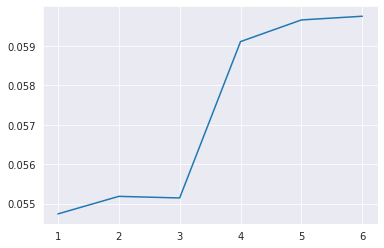

In [310]:
# Max Depth Tuning
# From initial testing, cross validation was necessary when testing the different values as the model was starting to overfit on the single validation set. 
# BEWARE - TAKES 5-10 MINUTES TO RUN
max_depth_vals_vec=list(range(1,7))
param_exploration(param_name="max_depth", param_vals=max_depth_vals_vec, cross_val=True)

### Other boosting parameters
There are other parameters that can yield improvements if tuned appropriately which fall into several groups, and different packages handle them (and name them) differently.


#### Data (row) sampling parameters
How to choose the data for each tree.  Unlike Random Forest, "Standard" boosting just uses the whole data set for each tree.  However, you can choose to sample a fraction of the data to add regularization.
- subsample, replacement, etc.

#### Feature sampling parameters
Unlike Random Forest, the default in gradient boosting is to check every feature at every node.  Since boosting is not relying on having uncorrelated trees, it can still give good results without this randomization.  However, randomly sampling features can help regularize, in addition to speeding up training (it is faster to train if you don't check every column every time). XGBoost permits subsampling features per tree, level, *and* node.
- Examples: colsample_bynode, colsample_bytree, colsample_bylevel

#### Split sampling parameters
For each feature, should we check all possible splits, or reduce the number through approximation
- Examples: tree_method, sketch_eps in XGBoost

#### Regularization parameters
Other regularization parameters include:
- minimum "improvement" required to make a split
- "Shrinkage" of the leaf values of the trees (as in LASSO / Ridge regression)
- gamma, reg_lambda, reg_alpha



## Manually Exploring Parameters (One by One) 

**Warning**: Each of the plots generated below take a few minutes to run. 

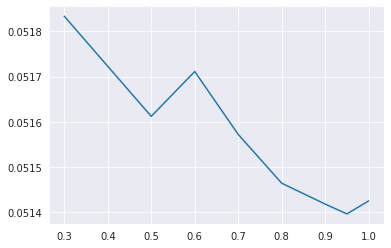

In [311]:
# Subsample: Fraction of dataset to use to build each tree
param_vals_vec=[0.3, 0.5, 0.6, 0.7, 0.8, 0.9, .95, 1]
param_exploration(param_name="subsample", param_vals=param_vals_vec, cross_val=False)

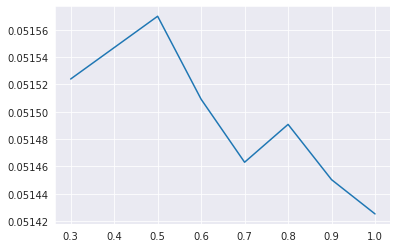

In [312]:
# ColSample By Tree: Ration of columns chosen when constructing each tree
param_vals_vec=[0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
param_exploration(param_name="colsample_bytree", param_vals=param_vals_vec, cross_val=False)

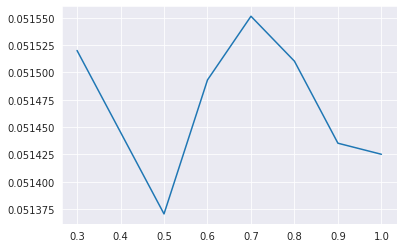

In [313]:
# ColSample By Node: Ratio of columns chosen at each node (split)
param_vals_vec=[0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
param_exploration(param_name="colsample_bynode", param_vals=param_vals_vec, cross_val=False)

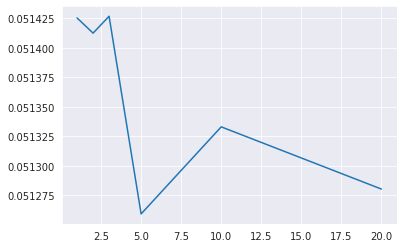

In [314]:
# Reg Lambda: Regularization parameter from Ridge Regression, the larger the value, the more conservative the algorithm
param_vals_vec=[1, 2, 3, 5, 10, 20]
param_exploration(param_name="reg_lambda", param_vals=param_vals_vec, cross_val=False)

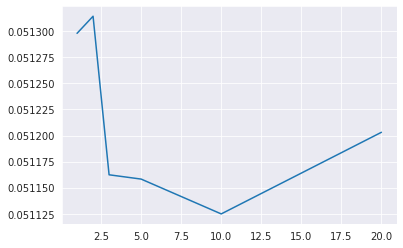

In [315]:
# Reg Alpha: Regularization parameter from Lasso Regression, the larger the value, the more conservative the algorithm
param_vals_vec=[1, 2, 3, 5, 10, 20]
param_exploration(param_name="reg_alpha", param_vals=param_vals_vec, cross_val=False)

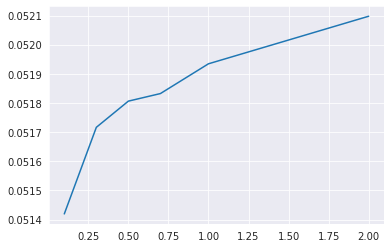

In [316]:
# Gamma: Another regularization paramter - the larger the value, the more conservative the algorithm
param_vals_vec=[0.1, 0.3, 0.5, 0.7, 1, 2]
param_exploration(param_name="gamma", param_vals=param_vals_vec, cross_val=False)

## Setting Parameters in Gradient Boosting
There are several approaches to finding the best parameters for your Gradient Boosting Model
1. Do a massive "grid search"
2. Just play around manually
3. "Smart" parameter search that tries to search promising combinations

There are drawbacks to all of these:
- Grid search is extremely time consuming
- It is difficult to know if you are choosing appropriate parameters and ranges
- There may be other considerations than just metric performance (model size, coherence, training time)
- Manual approaches are haphazard, attention consuming
- Smart approaches are not always as smart as they could be

### Suggested hybrid approach
1. Use early stopping, low learning rate, high number of trees (to remove learning rate and number of estimators from the search)
1. Run hyperopt with a few parameters (including max_depth) to "understand the landscape"
1. Iteratively refine your ranges and add more parameters to the search


## Hyperopt Package

Instead of exhaustively searching a huge parameter space, focus the search on "promising" areas of the search space (based on findings seen so far).

The `hyperopt` package is a python library for search spaces optimizing and overall does a reasonably good job of seraching the parameter space. For a detailed tutorial on Hyperopt usage on different Gradient Boost algorithm, refer to this [medium article](https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e). 


In [317]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

Must define the "loss function" which takes a set of parameters and output the loss value

In [ ]:
def eval_model(params):
    xgb_base = xgb.XGBRegressor()
    xgb_base.set_params(**params)
    
    # TESTING WITH SINGLE VALIDATION SET
#     xgb_base.fit(X_prepared, y_train, eval_set=[(X_prepared_val, y_val)], early_stopping_rounds=20,
#                 eval_metric='mae', verbose=False)
#     preds = xgb_base.predict(X_prepared_val)
#     mae = mean_absolute_error(y_val, preds)
    
    # TESTING WITH CROSS VALIDATION
    fit_params={'early_stopping_rounds': 15, 
            'eval_metric': 'mae',
            'verbose': False,
            'eval_set': [[X_prepared_val, y_val]]}
    mae = -cross_val_score(xgb_base, X_prepared, y_train, scoring="neg_mean_absolute_error", cv=3)
    mae = mae.mean()
    
    return(mae)

- Next, we define the parameter space.  
- There are several options to define ranges.
    - `randint`: chooses a random integer between 0 and an upper bound 
    - `choice`: choose from a set of specific values
    - `uniform`: choose a (float) in the range
    - `quniform`: choose a discrete range of floats
    
See more at hyperopt documentation:
http://hyperopt.github.io/hyperopt/getting-started/search_spaces/

In [319]:
fspace1 = {
    'max_depth':hp.randint('max_depth', 7), # goes up to 6-1
    'colsample_bynode': hp.uniform('colsample_bynode',.3,1),
    'subsample': hp.quniform('subsample',.3, 1,.05),
    'gamma':hp.uniform('gamma',.2, 5),
    'tree_method': hp.choice('tree_method', ['approx', 'exact']),
    'n_estimators': 10000,
    'learning_rate': 0.15,
    'random_state': 42,
}

In [320]:
# Finally, we use the `fmin` function and record our trials in a `Trials` object
# BEWARE: THIS CODE TOOK 7+ HOURS TO RUN WHEN PERFORMING 1200 TRIALS
trials1 = Trials()
best_param = fmin(fn=eval_model, space=fspace1, algo=tpe.suggest, max_evals=10, trials=trials1)

100%|██████████| 10/10 [08:23<00:00, 50.36s/trial, best loss: 0.0532258357127337] 


In [321]:
best_param

{'colsample_bynode': 0.616750234516522,
 'gamma': 0.9542639724795898,
 'max_depth': 3,
 'subsample': 0.8,
 'tree_method': 1}

The individual trials can be explored to detect trends within specific parameters 


In [322]:
# Extract data from hyperopt trials 
max_depth_trial_vals = np.array([t['misc']['vals']['max_depth'] for t in trials1.trials])
ss_trial_vals = np.array([t['misc']['vals']['subsample'] for t in trials1.trials])
gamma_trial_vals = np.array([t['misc']['vals']['gamma'] for t in trials1.trials])
loss_trial_vals = np.array([t['result']['loss'] for t in trials1.trials])
trial_nums = np.array([t['tid'] for t in trials1.trials])

Plot trends between different parameter values and corresponding losses. 

For example, the ``max_depth`` plot shows decreasing losses with an increase in depth which plateaus are a certain value - due to Kaggle notebook refreshing at startup, the plot for 1200 trials experiment in unavailable anymore :(


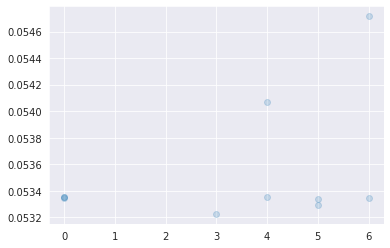

In [323]:
# Plot trends between different parameter values and corresponding losses 
plt.scatter(max_depth_trial_vals, loss_trial_vals, alpha=.2)
# plt.scatter(ss_trial_vals, loss_trial_vals, alpha=.2)
# plt.scatter(gamma_trial_vals, loss_trial_vals, alpha=.2)

### Best Params Model 

Based on the 1200 ``hyperopt`` trials, the following hyperparameter values had the best loss: 
```
{'colsample_bynode': 0.382,
 'gamma': 0.201,
 'max_depth': 5,
 'subsample': 0.95,
 'tree_method': 'exact'}
```

The other important parameters (``learning_rate``, ``n_estimators``) were already set. 

In [324]:
fit_params={
    'early_stopping_rounds': 15, 
    'eval_metric': 'mae',
    'verbose': False,
    'eval_set': [[X_prepared_val, y_val]],
}

best_params = {
    'colsample_bynode': 0.75,   
    'gamma': 0.201,
    'max_depth': 5,   
    'subsample': 0.95, 
    'tree_method': 'exact',
    'learning_rate': 0.01,
    'n_estimators': 10000,
    'random_state': 42,
}

xgb_base = xgb.XGBRegressor(**best_params)
xgb_base.fit(X_prepared, y_train, **fit_params)
get_cross_val_scores([xgb_base], X_prepared, y_train, cv=3, fit_params=fit_params)

--------------------------------------------------
Model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=0.75, colsample_bytree=1, gamma=0.201, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=4, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.95,
             tree_method='exact', validate_parameters=1, verbosity=None)

Scores: [0.05414556 0.05322625 0.0607351 ]

Mean: 0.05603563499804807

Standard deviation: 0.0033441499977830504


# 4-b) LightGBM

LightGBM came out around 2017 and is written by researchers at Microsoft Research. Its major advances include: 

- Smarter techniques to avoid searching all splits and speeding things up (ignoring small gradients to reduce data at each iteration)
- "looks for" mutually exclusive features to handle them better
- Instead of building decision trees one level at a time like XGBoost, LightGBM uses a leaf-wise tree growth approach which results in fewer unnecesary nodes. 

Given the already long length of this notebook, I will not go into too many detailed explanations about LightGBM. **However, from my limited time using LightGBM, I am already enjoying working with it more than XGBoost - primarily due to the performance boost when training which feels MAGNITUDES faster than XGBoost. The performance boost does NOT come with a tradeoff in model accuray - LightGBM basic model is performing better than the fully tuned XGBoost model.** 

### LightGBM Resources: 
- [Intro to LightGBM and Performance vs XGBoost](https://towardsdatascience.com/how-to-beat-the-heck-out-of-xgboost-with-lightgbm-comprehensive-tutorial-5eba52195997)
- [Understanding LightGBM Parameters - Detailed Guide](https://neptune.ai/blog/lightgbm-parameters-guide) 
- [Guide to tuning LightGBM using Optuna](https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5)


In [325]:
import lightgbm as lgbm
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
import optuna  # !pip install optuna
from optuna.integration import LightGBMPruningCallback

In [326]:
X_prepared = X_train.copy()
X_prepared_val = X_val.copy()

In [327]:
class ConvertToCategorical(BaseEstimator, TransformerMixin): 
    '''
    Pipeline to convert categorical variables to Pandas Category type. 
    This pipeline is specific to LGBM which handles categorical vars differently.
    '''
    def __init__(self, cat_vars):
        self.cat_vars = cat_vars
        
    def fit(self, X, y=None): 
        return self  # Nothing else to do 
    
    def transform(self, X): 
        for col in self.cat_vars: 
            X[col] = pd.Categorical(X[col])
        return X
      
# Code to test pipeline
# convert_to_cat = ConvertToCategorical(cat_vars=cat_vars)
# X_temp = convert_to_cat.fit_transform(X_temp)

In [328]:
# Feature Dropper Pipeline 
var_drop = ['parcelid',]
feature_dropper = FeatureDropper(features_to_drop=var_drop)

# Convert Date Features Pipeline
year_feat_creator = CreateYearFeatures(date_features=date_features)

# Date Feature Creator
date_feat_creator = CreateDateFeatures()

# Derived Features Creator
derived_feat_creator = CreateDerivedFeatures()

# Feature Encoding Pipeline
cat_vars = ['transaction_year', 'transaction_month', 'transaction_day', 'transaction_quarter', 'airconditioningtypeid', 
            'buildingqualitytypeid', 'fips', 'heatingorsystemtypeid', 'propertylandusetypeid', 'regionidcity', 'regionidcounty', 
            'regionidneighborhood', 'regionidzip', 'assessmentyear', 'typeconstructiontypeid', 'architecturalstyletypeid', 
            'buildingclasstypeid', 'pooltypeid2', 'pooltypeid7', 'storytypeid',  'hashottuborspa', 'pooltypeid2', 
            'taxdelinquencyyear',  'taxdelinquencyflag', 'fireplaceflag', 'decktypeid', 'pooltypeid10', 
            'propertycountylandusecode', 'propertyzoningdesc', 'rawcensustractandblock', 'censustractandblock'
           ]
# Feature Encoding Pipeline
feature_encoder = ColumnTransformer([
    ("ohe_cats", OneHotEncoder(handle_unknown='ignore'), cat_vars)],
    remainder='passthrough'
)

### LightGBM Categorical Handling 

LightGBM handles categorical variables different from other models which mainly use One-Hot Encoding. It handles categorical variables by ranking their marginal target value in each node. 

For this problem, we tested using both One-Hot Encoding and LightGBM's approach and decided to use OHE which performed much better. 


In [329]:
lgbm_preprocessor = Pipeline([
    ('derived_feat_creator', derived_feat_creator),
    ('feature_dropper', feature_dropper),
    ('date_feat_creator', date_feat_creator),
    ('year_feat_creator', year_feat_creator),
    ('feature_encoder', feature_encoder),
])

data_prep_pipe = lgbm_preprocessor.fit(X_prepared)
X_prepared = lgbm_preprocessor.transform(X_prepared)
X_prepared_val = lgbm_preprocessor.transform(X_prepared_val)

In [245]:
X_lgbm = X_prepared.copy()
X_lgbm_val = X_prepared_val.copy()

In [330]:
# Initialize LightGBM Model 
params = {
    'n_estimators': 10000,
    'random_state': 42
}

# Fit model using early stopping and validation set 
fit_params={'early_stopping_rounds': 30, 
            'eval_metric': 'mae',
            'verbose': False,
            'eval_set': [[X_prepared_val, y_val]]
           }

lgbm_base = lgbm.LGBMRegressor(**params)
lgbm_base.fit(X_prepared, y_train, **fit_params)
get_cross_val_scores([lgbm_base], X_prepared, y_train, cv=3, fit_params=fit_params)

--------------------------------------------------
Model: LGBMRegressor(n_estimators=10000, random_state=42)

Scores: [0.05408776 0.05310332 0.05192301]

Mean: 0.05303802913507818

Standard deviation: 0.0008849624059724484


## LightGBM Hyperparameter Tuning (Using Optuna)

By the time I reached LightGBM for this project, I encountered another hyperparameter tuning package called ``Optuna`` which is much newer and more maintained than ``hyperopt``. Thus, I decided to use Optuna for LightGBM tuning. Optuna claims to perform better tuning than TPE (Tree-structured Parzem Estimator) algorithms which is used by ``hyperopt`` - I am unable to speak to it's comparative performance but did find the package usage and documentation better than hyperopt. 

### Resources Used: 
- [Guide to tuning LightGBM using Optuna](https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5)
- [LightGBM Tuner: New Optuna Integration for Hyperparameter Optimization](https://medium.com/optuna/lightgbm-tuner-new-optuna-integration-for-hyperparameter-optimization-8b7095e99258)


In [ ]:
def objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.1),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1),
    }
    
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgbm.LGBMRegressor(**param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="mae",
            verbose=False,
            early_stopping_rounds=25,
            callbacks=[
                LightGBMPruningCallback(trial, "l1")
            ],  # Add a pruning callback
        )
        preds = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_scores)

In [ ]:
# Similar to Hyperopt - this code creates an experiment using the objective function and parameter grid above
study = optuna.create_study(direction="minimize", study_name="LGBM Regressor")
func = lambda trial: objective(trial, X_prepared, y_train.to_numpy())
study.optimize(func, n_trials=10000)

In [ ]:
print(f"\tBest value (mae): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

### Best Params Model 

Based on the 10000 ``Optuna`` trials, the following hyperparameter values had the best loss: 
```
best_params = {
    'num_leaves': 512,
    'max_depth': 9,
    'lambda_l2': 15,
    'bagging_fraction': 0.9,
    'feature_fraction': 0.6,
    'learning_rate': 0.01,
    'n_estimators': 10000,
    'random_state': 42,
}

```

The other important parameters (``learning_rate``, ``n_estimators``) were already set.

In [331]:
fit_params={
    'early_stopping_rounds': 30, 
    'eval_metric': 'mae',
    'verbose': False,
    'eval_set': [[X_prepared_val, y_val]]
}

best_params = {
    'num_leaves': 512,
    'max_depth': 9,
    'lambda_l2': 15,
    'bagging_fraction': 0.9,
    'feature_fraction': 0.6,
    'learning_rate': 0.01,
    'n_estimators': 10000,
    'random_state': 42,
}

lgbm_base = lgbm.LGBMRegressor(**best_params)
lgbm_base.fit(X_prepared, y_train, **fit_params)
get_cross_val_scores([lgbm_base], X_prepared, y_train, cv=3, fit_params=fit_params)

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored.

# 4-c) CatBoost

Catboost came out around 2017-2018 (paper in NeurIPS 2018), written by a group of researchers at Yandex.  Its major advances include: 

- Allows native handling of categorical variables (as strings).  Specifically, it performs on-the-fly *numerical encoding* of categorical variables, with a clever encoding scheme to reduce overfitting (their paper argues that the standard approach of LightGBM overfits).  
- Similar to LightGRM, it is also highly optimized and very fast.

Similar to LightGTM, I will not go into too many detailed explanations given the already long length of the notebook. **However, from my limited time using CatBoost, I find it to be faster than XGBoost but slower than LightGBM. In terms of model accuracy, CatBoost's default parameters model performs better than the fully tuned XGBoost and LightGBM.**

### CatBoost Resources: 
- [CatBoost Hyper-Parameter Optimization with Optuna](https://towardsdatascience.com/hyper-parameter-optimization-with-optuna-4920d5732edf)
- [CatBoost HyperParameter Tuning with Optuna!](https://www.kaggle.com/saurabhshahane/catboost-hyperparameter-tuning-with-optuna)


In [332]:
import catboost as cb
import optuna 
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

In [333]:
X_prepared = X_train.copy()
X_prepared_val = X_val.copy()

In [334]:
# Feature Dropper Pipeline
var_drop = ['parcelid',]
feature_dropper = FeatureDropper(features_to_drop=var_drop)

# Convert Date Features Pipeline
year_feat_creator = CreateYearFeatures(date_features=date_features)

# Feature Encoding Pipeline
cat_vars = ['transaction_year', 'transaction_month', 'transaction_day', 'transaction_quarter', 'airconditioningtypeid', 
            'buildingqualitytypeid', 'fips', 'heatingorsystemtypeid', 'propertylandusetypeid', 'regionidcity', 'regionidcounty', 
            'regionidneighborhood', 'regionidzip', 'assessmentyear', 'typeconstructiontypeid', 'architecturalstyletypeid', 
            'buildingclasstypeid', 'pooltypeid2', 'pooltypeid7', 'storytypeid',  'hashottuborspa', 'pooltypeid2', 
            'taxdelinquencyyear',  'taxdelinquencyflag', 'fireplaceflag', 'decktypeid', 'pooltypeid10', 
            'propertycountylandusecode', 'propertyzoningdesc', 'rawcensustractandblock', 'censustractandblock'
           ]
convert_to_cat = ConvertToType(var_type='str', vars_to_convert=cat_vars)

# Date Feature Creator
date_feat_creator = CreateDateFeatures()

# Derived Features Creator
derived_feat_creator = CreateDerivedFeatures()

# Aggregated Feature Creator
group_col = 'regionidcity'
agg_cols = ['lotsizesquarefeet', 'yearbuilt', 'calculatedfinishedsquarefeet',
            'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'property_tax_per_sqft']
aggregated_feat_creator = CreateAggregatedFeatures(group_col=group_col, agg_cols=agg_cols)

### CatBoost Categorical Handling 

CatBoost handles categorical variables natively which is different from other models that use One-Hot Encoding. It handles categorical variables by ranking their marginal target value in each node. 

For this problem, we tested using both One-Hot Encoding and CatBoost's on-the-fly numerical encoding approach and decided to use CatBoost's built-in categorical handling which performed much better. 


In [335]:
cb_preprocessor = Pipeline([
    ('derived_feat_creator', derived_feat_creator),
#     ('aggregated_feat_creator', aggregated_feat_creator),
    ('feature_dropper', feature_dropper),
    ('date_feat_creator', date_feat_creator),
    ('year_feat_creator', year_feat_creator),
    ('convert_to_cat', convert_to_cat),
])

data_prep_pipe = cb_preprocessor.fit(X_prepared)
X_prepared = cb_preprocessor.transform(X_prepared)
X_prepared_val = cb_preprocessor.transform(X_prepared_val)

In [336]:
X_cb = X_prepared.copy()
X_cb_val = X_prepared_val.copy()

In [ ]:
# Initialize CatBoost Model 
params = {
    'n_estimators': 10000,
    'random_state': 42,
    'eval_metric': 'MAE',
}

# Fit model using early stopping and validation set 
fit_params={
    'eval_set': (X_prepared_val, y_val),
    'cat_features': cat_vars,
    'early_stopping_rounds': 10, 
    'verbose': False,
}

cb_base = cb.CatBoostRegressor(**params)
cb_base.fit(X_prepared, y_train, **fit_params)

In [338]:
get_eval_metrics([cb_base], X_prepared_val, y_val)
# get_cross_val_scores([cb_base], X_prepared, y_train, cv=3, fit_params=fit_params)

Model: <catboost.core.CatBoostRegressor object at 0x7f7dbb3025d0>
MAE: 0.05115943914333928, RMSE: 0.08177128676909469


## CatBoost Hyperparameter Tuning (Using Optuna)

Given the better documentation for Optuna compared to ``hyperopt``, I decided to continue using it for CatBoost Hyperparameter tuning. 

In [ ]:
def objective(trial, X, y):    
    param_grid = {
        # Fixed Params
        "eval_metric": "MAE",
        "n_estimators": 10000,
        "random_state": 42,
    
        # Tuned Params
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.05, 0.3),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e1),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20),  
    }
    # Conditional Hyper-Parameters
    if param_grid["bootstrap_type"] == "Bayesian":
        param_grid["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param_grid["bootstrap_type"] == "Bernoulli":
        param_grid["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    
    cv = KFold(n_splits=3, shuffle=True, random_state=42)

    cv_scores = np.empty(3)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = cb.CatBoostRegressor(**param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            cat_features=cat_vars,
            early_stopping_rounds=20,
            verbose=False
        )
        preds = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_scores)

In [ ]:
# Similar to Hyperopt - this code creates an experiment using the objective function and parameter grid above
study = optuna.create_study(direction="minimize", study_name="CatBoost Regressor")
func = lambda trial: objective(trial, X_prepared, y_train.to_numpy())
study.optimize(func, n_trials=400)

In [ ]:
print(f"\tBest value (mae): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

### Best Params Model 

Based on the 400 ``Optuna`` trials, the following hyperparameter values had the best loss of MAE: 0.05265
```
best_params = {
    'learning_rate': 0.01,
    'l2_leaf_reg': 3,
    'depth': 6,
    'n_estimators': 900,
    'random_state': 42,
    'eval_metric': 'MAE',
    'loss_function': 'MAE'
}
```

In [346]:
best_params = {
    'learning_rate': 0.03,
    'l2_leaf_reg': 3,
    'depth': 6,
    'n_estimators': 900,
    'random_state': 42,
    'eval_metric': "MAE",
    'loss_function': 'MAE',
}

fit_params={
    'cat_features': cat_vars,
    'verbose': False,
}

cb_base = cb.CatBoostRegressor(**best_params)
cb_base.fit(X_prepared, y_train, **fit_params)

get_eval_metrics([cb_base], X_prepared_val, y_val)
# get_cross_val_scores([cb_base], X_prepared, y_train, cv=3, fit_params=fit_params)

Model: <catboost.core.CatBoostRegressor object at 0x7f7d67d61710>
MAE: 0.05095291350986744, RMSE: 0.08196273754516807


# Model Interpretability 

An important aspect of machine learning model building is to be able to understand and evaluate the models **beyond** simple metrics on their test set performance to be able to trust the model. **This interpretation is extremely cruicial for complex models such as gradient boosting machines which usually perform better than easy to explain models such as Linear Regression, and thus require greater care when being used.** 

Interpretability can include answering questions such as: 

1. Which variables are most important to my model *in general*? 
1. What is the nature of the relationship between the predictors and the target? 
1. Are there significant interaction effects?
1. For a specific prediction, what were the most important reasons leading to that prediction? 

**Generally, we will be exploring two different types of feature importances as we look to better interpret our earlier models:** 

1. **Global Feature Importance**: Does the model make predictions based on reasonable features? 
2. **Local Feature Importance**: Can we trust the model's prediction for one specific data point? 

## 1. Global Feature Importance

We have already briefly explored global feature importances earlier when using `feature_importances_` parameter of the Random Forest Regressor. These values are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree. 

Similar functions are avaiable for **XGBoost except the feature importance values can be different based on the metric used for calculations. There are five different importance types:**

- ``weight``: the number of times a feature is used to split the data across all trees.
- ``gain``: the average gain across all splits the feature is used in.
- ``cover``: the average coverage across all splits the feature is used in.
- ``total_gain``: the total gain across all splits the feature is used in.
- ``total_cover``: the total coverage across all splits the feature is used in.

The code sample below shows feature importances for the different gradient boosting models explored with a mini deep dive into CatBoost global feature importances. 
```
xgb_base.get_booster().get_score(importance_type='gain')
lgbm_base.feature_importances_
cb_base.get_feature_importance()
```

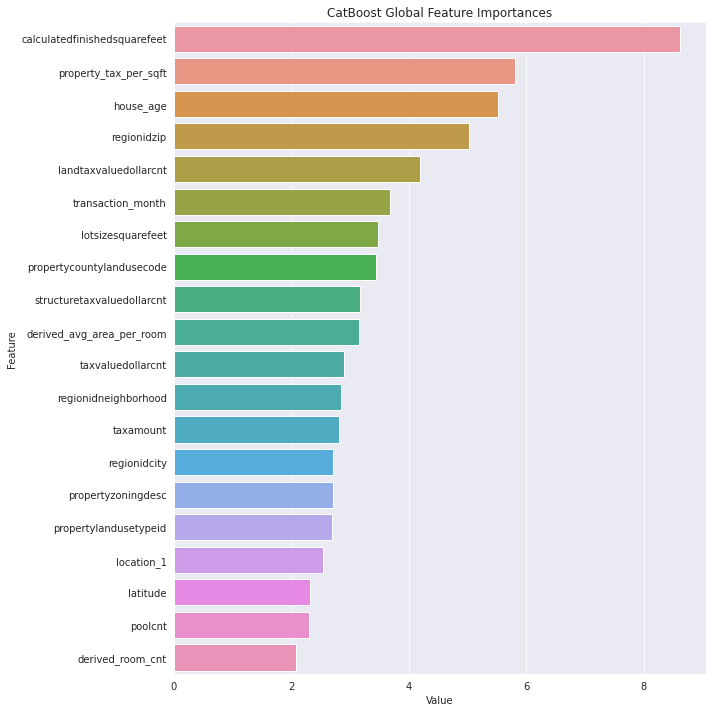

In [349]:
cb_importances = cb_base.get_feature_importance()
cb_importances = pd.DataFrame(sorted(zip(cb_importances, X_cb.columns)), columns=['Value','Feature'])

# Select 15 most important features
cb_importances = cb_importances.sort_values(by='Value', ascending=False)[:20]

# Plot importances 
plt.figure(figsize=(10, 10))
sns.barplot(x="Value", y="Feature", data=cb_importances.sort_values(by="Value", ascending=False))
plt.title('CatBoost Global Feature Importances')
plt.tight_layout()
plt.show()

Analyzing the plot above shows how the location related features (``propertycountylandusecode``, ``regionidzip``) are some of the most important followed by the age of house and ``calculatedfinishedsquarefeet``. 

## 2. Local Feature Importance 

Local importance tries to help explain how different feature might be interaction and how the model makes a **specific** prediction. We will be highlighting two different tools to help with this: 

1. **ICE (Individual Conditional Expectation) Plots**: Excellent tool to understand "what the model is thinking" (examples below will clarify how they do this). 
2. **SHAP**: Motivated by "Shapley Value" in Game Theory, this aims to explain why a particular instance is "different" from average and which features contribute to the *specific* prediction. 

### ICE Plots 
 
Individual Conditional Expectation (ICE) plots display one line per instance that shows how the instance’s prediction changes when a feature changes. The values for a line (and one instance) can be computed by keeping all other features the same, creating variants of this instance by replacing the feature’s value with values from a grid and making predictions with the black box model for these newly created instances. The result is a set of points for an instance with the feature value from the grid and the respective predictions.

How do ICE plots work?
- Take an actual data point and see what the model predicts.
- Pick a variable and change the value of that variable (over some range of values).
- Plot the model prediction as a function of the "altered" value
- Do this for multiple points, and plot on the same graph
- Do this for all variables of interest

In [352]:
# !pip install ml_insights  #if you don't have it installed
import ml_insights as mli

In [368]:
range_pts = mli.get_range_dict(X_cb)
test_pts = X_cb_val.sample(5, random_state=40)
imp_num_feat = [
    'calculatedfinishedsquarefeet', 'house_age',
    'taxamount', 'structuretaxvaluedollarcnt', 'latitude', 
]

The ranges of values used for x-axis need to be updated to remove outliers to better interpret the ICE-plot.

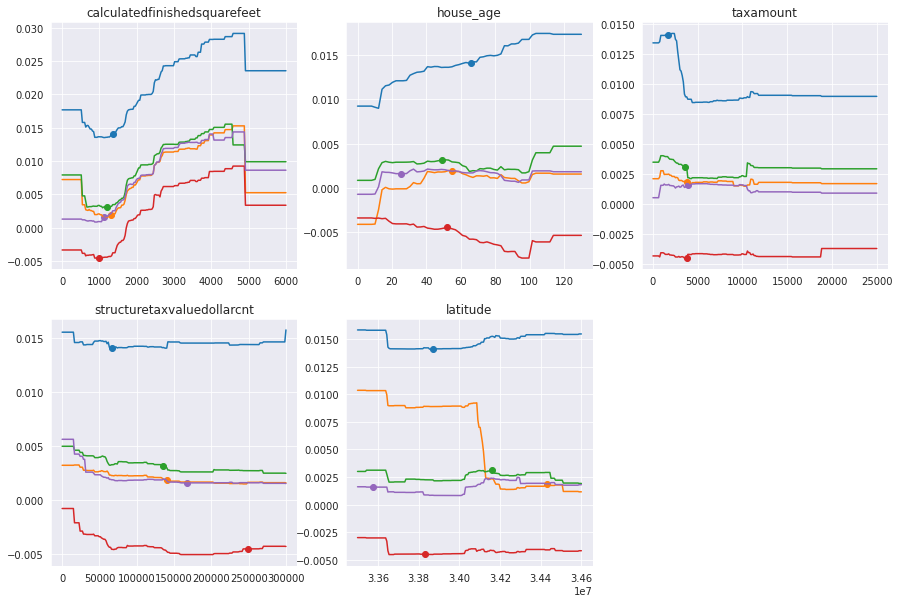

In [369]:
# Updating the ranges of features on x-axis for better interpretation 
range_pts['calculatedfinishedsquarefeet'] = np.linspace(0, 6000, 200)
range_pts['house_age'] = np.linspace(0, 130, 65)
range_pts['taxamount'] = np.linspace(0, 25000, 200)
range_pts['structuretaxvaluedollarcnt'] = np.linspace(0, 300000, 200)
range_pts['latitude'] = np.linspace(3.35e+07, 3.46e+07, 200)

mli.ice_plot(cb_base, test_pts, imp_num_feat, range_pts=range_pts, pred_fn='predict', figsize=(15,10))

### Interpreting ICE plots

Things to look for: 
- When the line is flat, that means the variable is unimportant in that range (for that particular data point)
- When the line is steep, that means the variable has a strong effect on the target in that range.
- If the line is very wiggly, this often betrays some degree of "overfitting" in the model.  Interestingly, this is often *not* reflected in the test set metrics.  However, it is reflective of the "coherence" of the model.  It also may reflect a paucity of training data in that region
- If all the lines show the same basic effect, this suggests that there is little interaction.
- If some lines have very different trajectories, this indicates a high degree of interactivity.


**NOTE: ICE-plots tell us what the *model* thinks.  To the extent that the model is reflective of the "real world" that generated the data, it may be useful in understanding the real world.  However, it may also be demonstrating places where the model is wrong, has little data, or is displaying artifacts of the way it was trained.  This is where our "human" thinking can be combined with the model to try and understand the world better.**

## SHAP: Explaining Individual Predictions

Goal of SHAP values is to: 
- Explain why a particular instance is "different" from average.
- Which features / concepts contributed most to its "distinctiveness"?
- Can we attribute the "distance from average" of a particular case to the individual features?


**Note: If you're unfamiliar with SHAP Values completely, we will only be explaining it briefly here due the notebook's already long length. I highly recommend this [insightful article on SHAP for Interpretability](https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/) to better understand how they work.**

In [371]:
# !pip install shap #if you don't have it installed
import shap
shap.initjs()

In [373]:
explainer = shap.Explainer(cb_base)
shap_values = explainer(X_cb)

# The SHAP expected value is the median of the target variable 
explainer.expected_value, np.mean(y_train)

(0.006185755399220628, 0.0084656466741088)

### Waterfall Plots

SHAP explains how individual predictions are arrived at in terms of the contributions from each of the model's input variables. This is a highly intuitive approach that produces simple but informative outputs. 

Waterfall plots the most complete display of a single prediction. The waterfall structure emphasizes the additive nature of positive and negative contributors, and how they build on the *base value* to yield the model's prediction, $f(x)$

**Note: Unfortunately, the target feature values in our Zillow project are extremely tiny (mean of 0.008) and thus, the contributions shown in most charts below will be zero due to rounding. HOWEVER, the positive and negative contributions can still be gauged based on the magntitude of the various chart elements**


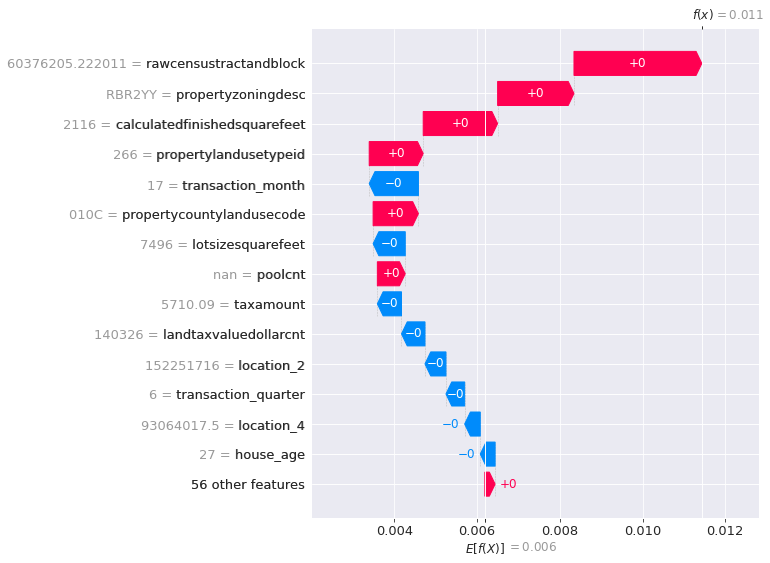

In [ ]:
i_med = np.argsort(y_train)[len(y_train)//2 + 2]       # Median (offset by 2 due to missing index error)
i_71 = np.argsort(y_train)[int(len(y_train)*0.75)] # 75th percentile
i_20 = np.argsort(y_train)[int(len(y_train)*0.20)]  # 20th percentile
plt.style.use('default') 
shap.plots.waterfall(shap_values[i_71], max_display=15)

### Force Plots 

Force plots are equivalent representations as Waterfall plots that display the key information is a more condensed format. 

In [382]:
# Force plot for median y_train value
shap.plots.force(shap_values[i_med])

In [383]:
# Force plot for 20th percentile y_train value
shap.plots.force(shap_values[i_20])

## SHAP for Global Interpretability 

Thanks to its versatility, SHAP values can also be used to get a sense of how "globally" important a feature is by aggregating the (absolute value of) the local feature values. These numbers can be thought of as the "average absolute impact" that a variable has on the prediction.

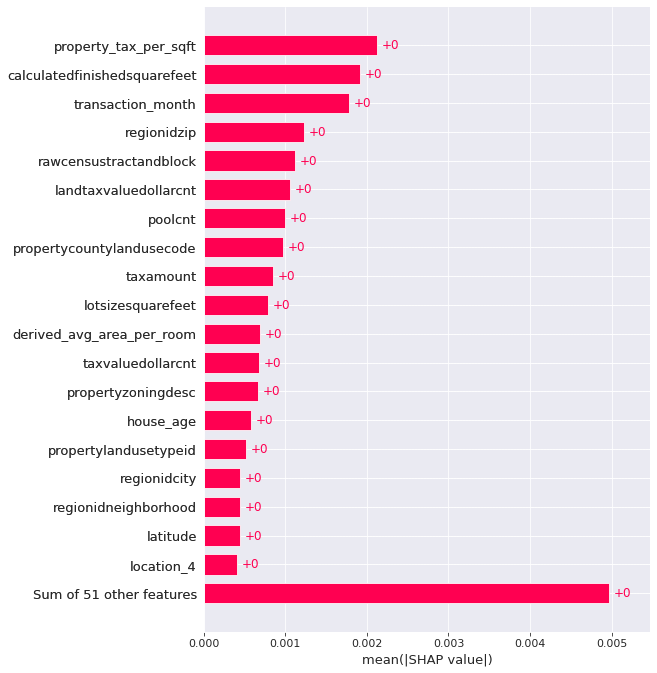

In [384]:
shap.plots.bar(shap_values, max_display=20)

**The bar plot of the absolute SHAP values paints an interesting and *slightly* different picture than the ``feature_importances_`` function earlier which said ``house_age`` was one of the most important feature. However, according to the SHAP bar plot above, there are many other variables that contribute greater to the final predicted value on average.**

**Furthermore, ``rawcensustractandblock`` and ``poolcnt`` are within top 7 contributors according to SHAP values compared to not even being in top 15 according to ``feature_importance_``. This can be a clue to further dig into these variables' impact and analyze whether their affects are postively or negatively affecting the model.** 

# Stacking Models 

Until now, we have been training individual learners, which will be referred to as **base learners** going forward. **Stacking** (sometimes called "stacked generalization") involves training a new algorithm  to combine the predictions of several base learners.

First, the base learners are trained using the available training data, then a combiner or meta algorithm, referred to as **meta learner or super learner**, is trained to make a final prediction based on the predictions of the base learners. Such stacked ensembles tend to outperform any of the individual base learners (eg. a single RF or GBM) and have been shown to represent an asymptotitcally optimal system for learning. 

This [diagram](https://media.geeksforgeeks.org/wp-content/uploads/20190515104518/stacking.png) visually shows the process of stacking models where 'Second level model' in the image refers to the **Meta Learner**. 

## Create Training Data For Meta Learners

There are two ways to create a training dataset for the Meta Learner: 
1. **Split training set into two subsets**:
    - The first subset is used to train the individual base learners (such as we have already done in earlier sections) 
    - The first layer's base learners are then used to make predictions on the second (held-out) set which ensures that the predictions are "clean", since the predictors never saw these instances during training. 
    - **Pros & Cons**: The biggest benefit is that this approach is simple and easy to implement. However, the major drawback is that we lose the size of training sets used to train both base learners and meta learner and are forced to compromise on the dataset sizes. 
2. **Out-of-Fold Predictions Dataset**: 
   - This approach uses K-Fold Cross Validation to train each individual base learner on K-1 folds and uses the Kth fold to generate out-of-fold predictions (i.e. the base learner has previously not seen the data in the Kth fold)
   - This approach is repeated K times for each base learner - every time the base learner is trained on K-1 folds and generates predictions on the Kth fold. 
   - **Pros**: The biggest benefit is that we're able to generate a full size training set for the Meta Learner by combining all the out-of-fold predictions from each base learner. 
   - **Cons**: This approach is more complex to implement and takes significantly longer to run as each base learner is trained K-times to generate the final training set for the Meta Learner. 
   
**This notebook chose the second approach and the cells below create individual functions to train each base learner followed by running K-fold training to generate the final training set for the Meta Learner.**

In [253]:
def fit_rf(X_prepared, y_train, random_state=42): 
    best_params = {
        'n_estimators': 400,
        'max_samples': 0.3,
        'max_depth': 70,
        'max_features': 0.6,
        'min_samples_leaf': 32,    
        'random_state': random_state, 
    }

    ran_forest = RandomForestRegressor(**best_params)
    ran_forest.fit(X_prepared, y_train)
    return ran_forest

In [254]:
def fit_xgb(X_prepared, y_train, random_state=42): 
    fit_params={
        'early_stopping_rounds': 15, 
        'eval_metric': 'mae',
        'verbose': False,
        'eval_set': [[X_xgb_val, y_val]],
    }

    best_params = {
        'colsample_bynode': 0.75,   
        'gamma': 0.201,
        'max_depth': 5,   
        'subsample': 0.95, 
        'tree_method': 'exact',
        'learning_rate': 0.01,
        'n_estimators': 10000,
        'random_state': random_state,
    }

    xgb_base = xgb.XGBRegressor(**best_params)
    xgb_base.fit(X_prepared, y_train, **fit_params)
    return xgb_base

In [255]:
def fit_lgbm(X_prepared, y_train, random_state=42): 
    fit_params={
        'early_stopping_rounds': 30, 
        'eval_metric': 'mae',
        'verbose': False,
        'eval_set': [[X_lgbm_val, y_val]]
    }
    
    best_params = {
        'num_leaves': 512,
        'max_depth': 9,
        'lambda_l2': 15,
        'bagging_fraction': 0.9,
        'feature_fraction': 0.6,
        'learning_rate': 0.01,
        'n_estimators': 10000,
        'random_state': random_state,
    }

    lgbm_base = lgbm.LGBMRegressor(**best_params)
    lgbm_base.fit(X_prepared, y_train, **fit_params)
    return lgbm_base

In [256]:
def fit_catboost(X_prepared, y_train, random_state=42):    
    best_params = {
        'learning_rate': 0.03,
        'l2_leaf_reg': 3,
        'depth': 6,
        'n_estimators': 900,
        'random_state': random_state,
        'eval_metric': "MAE",
        'loss_function': 'MAE',
    }

    fit_params={
        'cat_features': cat_vars,
        'verbose': False,
    }

    cb_base = cb.CatBoostRegressor(**best_params)
    cb_base.fit(X_prepared, y_train, **fit_params)
    return cb_base

In [257]:
from sklearn.model_selection import KFold 

def get_out_of_fold_preds(X_prepared, y_train, model_fcn, random_state=42):
    """
    Use K-Fold Cross Validation to create out-of-fold predictions for supplied model. 
    The out-of-fold predictions can then be used to train a Meta Learner to further
    improve the model's performance.
    """
    model_preds = list()
    meta_y = list()
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    for train_ix, test_ix in kfold.split(X_prepared):
        # Depending on whether X_prepared is a dataframe or numpy array, uncomment one line below
#         train_X, test_X = X_prepared.iloc[train_ix], X_prepared.iloc[test_ix]
        train_X, test_X = X_prepared[train_ix], X_prepared[test_ix]
    
        train_y, test_y = y_train.iloc[train_ix], y_train.iloc[test_ix]
        
        model = model_fcn(train_X, train_y, random_state=random_state)
        preds = model.predict(test_X)
        meta_y.extend(test_y)
        model_preds.extend(preds)

    return model_preds, meta_y

In [ ]:
# Get Out-of-fold predictions for each base learner
# WARNING: This cell takes multiple hours to run (remove Random Forest regressor to save time which takes significantly longer than others)
xgb_preds, meta_y = get_out_of_fold_preds(X_xgb, y_train, fit_xgb)
lgbm_preds, meta_y = get_out_of_fold_preds(X_lgbm, y_train, fit_lgbm)
rf_preds, meta_y = get_out_of_fold_preds(X_rf, y_train, fit_rf)

In [ ]:
# Use .iloc line for split in get_out_of_fold_preds function
cb_preds, meta_y = get_out_of_fold_preds(X_cb, y_train, fit_catboost)

In [261]:
# Create meta_X training set by combining out-of-fold predictions from individual learners 
yhat1 = array(rf_preds).reshape((len(rf_preds), 1))
yhat2 = array(xgb_preds).reshape((len(xgb_preds), 1))
yhat3 = array(lgbm_preds).reshape((len(lgbm_preds), 1))
yhat4 = array(cb_preds).reshape((len(cb_preds), 1))

meta_X = hstack((yhat1, yhat2, yhat3, yhat4))
meta_X

array([[0.00897241, 0.00975428, 0.0066653 , 0.0015818 ],
       [0.00244369, 0.00652691, 0.00383548, 0.00367765],
       [0.0069091 , 0.00880139, 0.01175629, 0.00799854],
       ...,
       [0.00967284, 0.0072369 , 0.00774845, 0.00821521],
       [0.01924663, 0.01434041, 0.02564105, 0.00986705],
       [0.01708095, 0.01433379, 0.0278459 , 0.01422786]])

In [264]:
# Create validation datset for testing Meta Learner 

# Make predictions on original validation sets using originally trained base learners
xgb_val_preds = xgb_base.predict(X_xgb_val)
lgbm_val_preds = lgbm_base.predict(X_lgbm_val)
cb_val_preds = cb_base.predict(X_cb_val)
rf_val_preds = ran_forest.predict(X_rf_val)

# Create validation dataset
yhat1 = array(rf_val_preds).reshape((len(rf_val_preds), 1))
yhat2 = array(xgb_val_preds).reshape((len(xgb_val_preds), 1))
yhat3 = array(lgbm_val_preds).reshape((len(lgbm_val_preds), 1))
yhat4 = array(cb_val_preds).reshape((len(cb_val_preds), 1))
meta_X_val = hstack((yhat1, yhat2, yhat3, yhat4))
meta_X_val

array([[ 0.02039232,  0.01343699,  0.01812254,  0.01405842],
       [ 0.01316019,  0.00560057,  0.00720027,  0.00783324],
       [ 0.01055321,  0.00805963,  0.01028886,  0.00533286],
       ...,
       [ 0.01067826,  0.00530692,  0.01397103,  0.01070823],
       [-0.00981968, -0.02103386, -0.01279202,  0.0122948 ],
       [ 0.00544658,  0.00216624,  0.00726257,  0.0105679 ]])

In [265]:
meta_X.shape, meta_X_val.shape

((156227, 4), (8311, 4))

## Meta Learners

Train a Meta Learner using training set created from out-of-fold predictions of individual learners 

In [266]:
# Initialize LightGBM Model 
best_params = {
    'num_leaves': 128,
    'max_depth': 6,
    'lambda_l2': 15,
    'bagging_fraction': 0.6,
    'learning_rate': 0.01,
    'n_estimators': 10000,
    'random_state': 42,
}

# Fit model using early stopping and validation set 
fit_params={'early_stopping_rounds': 30, 
            'eval_metric': 'mae',
            'verbose': False,
            'eval_set': [[meta_X_val, y_val]]
           }

lgbm_stacked = lgbm.LGBMRegressor(**best_params)
lgbm_stacked.fit(meta_X, meta_y, **fit_params)

[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


LGBMRegressor(bagging_fraction=0.6, lambda_l2=15, learning_rate=0.01,
              max_depth=6, n_estimators=10000, num_leaves=128, random_state=42)

In [267]:
# CatBoost Meta Learner
best_params = {
    'learning_rate': 0.01,
    'l2_leaf_reg': 15,
    'depth': 6,
    'min_data_in_leaf': 32,
    'subsample': 0.6,
    'n_estimators': 10000,
    'random_state': 42,
    'eval_metric': "MAE",
}

fit_params={
    'eval_set': (meta_X_val, y_val),
    'early_stopping_rounds': 30, 
    'verbose': False,
}

cb_stacked = cb.CatBoostRegressor(**best_params)
cb_stacked.fit(meta_X, meta_y, **fit_params)

In [268]:
# Meta Model MAE on Validation Set
y_preds = lgbm_stacked.predict(meta_X_val)
# y_preds = cb_stacked.predict(meta_X_val)

mae = mean_absolute_error(y_val, y_preds)
rmse = mean_squared_error(y_val, y_preds, squared=False)
print(f"Stacked Model Evaluation")
print(f"MAE: {mae}, RMSE: {rmse}")

Stacked Model Evaluation
MAE: 0.050895196204782604, RMSE: 0.08130069536594724


# Combining Multiple Models 

In this section, we will not be using a new machine learning algorithm but rather use ensemble learning (similar to how Random Forest and GBMs do) to combine different learners that we have already trained. 

**By combining different learners trained earlier (Ridge / Lasso Regression, Random Forest, GBMs) in an ensemble, it can provide a final model that is more diverse than any of the individual models. This is because by combining diverse classifiers, it increases the chance that they will make very different types of errors, improving the ensemble's accuracy.**

**We can even combine the Stacking Algorithm with the individual base learners using different weights for each model to make the final predictions even more diverse.**

In [269]:
def create_model_preds(all_models, X):
    """
    Combine model predictions from different models using the input weights.
    
    all_models: List[Tuple(model, preprocessor)]
        List of a tuple of model info where each tuple has fitted model and data preprocessor 
    weights: List[]
        Weights for each model in all_models (must be same length as all_models)
    X: 
        Data to predict on
    """
    combined_preds = []
    for model_info in all_models: 
        model, preprocessor = model_info
        print(f"Starting preds for {model}")
        # Note: function below is defined in later section (Submission CSV Generation)
        model_pred = predict_in_chunks(model, preprocessor, X) 
        combined_preds.append(model_pred)
    return combined_preds
    
def combine_model_preds(combined_preds, weights, X):
    # Combine based on weights
    final_pred = np.empty(len(X))
    print(f"Combining with weights: {weights}")
    for idx, weight in enumerate(weights):
        final_pred += combined_preds[idx] * weight
    
    return final_pred

In [275]:
# Models to generate predictions for
all_models = [
    (ran_forest, rf_preprocessor),
    (xgb_base, xgb_preprocessor),
    (lgbm_base, lgbm_preprocessor),
    (cb_base, cb_preprocessor),
] 

# Creating Predictions for each model 
combined_preds = create_model_preds(all_models, df_test) # df_test is defined in next section (Submission CSV Generation)

Starting preds for RandomForestRegressor(max_depth=70, max_features=0.6, max_samples=0.3,
                      min_samples_leaf=32, n_estimators=400, random_state=42)
Starting preds for XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=0.75, colsample_bytree=1, gamma=0.201, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=4, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.95,
             tree_method='exact', validate_parameters=1, verbosity=None)
Starting preds for LGBMRegressor(bagging_fraction=0.9, feature_fraction=0.6, lambda_l2=15,
              learning_rate=0.01, max_depth=9, n_estimators=10000,
              num_leaves=512, random_state=42)
Starting preds for <catboost

In [276]:
# Create Meta_X from base learner predictions 
yhat1 = combined_preds[0].reshape((len(df_test), 1))
yhat2 = combined_preds[1].reshape((len(df_test), 1))
yhat3 = combined_preds[2].reshape((len(df_test), 1))
yhat4 = combined_preds[3].reshape((len(df_test), 1))

meta_X_submission = hstack((yhat1, yhat2, yhat3, yhat4))
meta_X_submission.shape

(2985217, 4)

In [277]:
# Create predictions from Meta Learners using outputs from individual learners
lgbm_stacked_pred = lgbm_stacked.predict(meta_X_submission)
cb_stacked_pred = cb_stacked.predict(meta_X_submission)

meta_combined_preds = [lgbm_stacked_pred, cb_stacked_pred]

### Combine Models Based on Weights

In this section, we can combine the predictions from the base learners and meta learners in any ratios that add up to 1. Testing with different weights can lead to a more diverse model with lower variance than any of the individual learners in most cases. 

**The best performing model combined predictions from ``LightGBM, CatBoost, Stacked_LightGBM`` with weights ``[0.20, 0.55, 0.25]`` respectively.** 



#### **The final model yielded in a Public Score of 0.06416 and a private score of 0.07497 which are within Top 250 and Top 60 respectively in the world out of over 3700 submissions.** 

In [300]:
# Models = [RF, XGB, LGBM, CB]
weights = [0.0, 0.0, 0.20, 0.55]
final_pred = combine_model_preds(combined_preds, weights, df_test)

# Models: [Stacked_LGBM, Stacked_CB]
weights = [0.25, 0.00]
print(f"Combining with weights: {weights}")
for idx, weight in enumerate(weights):
    final_pred += meta_combined_preds[idx] * weight

Combining with weights: [0.0, 0.0, 0.2, 0.55]
Combining with weights: [0.25, 0.0]


In [301]:
# Create final submission CSV using final test predictions 
sub = pd.read_csv('../input/zillow-prize-1/sample_submission.csv')
for c in sub.columns[sub.columns != 'ParcelId']:
    sub[c] = final_pred

print('Writing csv ...')
sub.to_csv('_9_Combined_plus_Stacked.csv', index=False, float_format='%.4f') 

Writing csv ...


# Submission CSV Generation

The following code runs a chosen model along with the Scikit-Learn Pipeline preprocessor to generate the final submission CSV using the Kaggle Test data. 

In [270]:
print('Loading Properties ...')
properties_2016 = pd.read_csv('../input/zillow-prize-1/properties_2016.csv', low_memory = False)

print('Loading Sample ...')
sample_submission = pd.read_csv('../input/zillow-prize-1/sample_submission.csv', low_memory = False)
sample_submission['parcelid'] = sample_submission['ParcelId']

print('Concat Train 2016 & 2017 ...')
df_test = pd.merge(sample_submission[['parcelid']], properties_2016, how = 'left', on = 'parcelid')
df_test['transactiondate'] = pd.Timestamp('2016-12-01') 
df_test.shape

Loading Properties ...
Loading Sample ...
Concat Train 2016 & 2017 ...


(2985217, 58)

In [ ]:
del properties_2016, sample_submission; gc.collect()

In [272]:
def chunker(seq, size):
    """Function to iterate over dataframe in chunks."""
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def predict_in_chunks(model, preprocessor, df_test): 
    final_pred = []

    for group in chunker(df_test, 300000):
        group = preprocessor.transform(group)
        pred = model.predict(group)
        final_pred.append(pred)
        del group; gc.collect()
        del pred; gc.collect()
    return np.concatenate(final_pred).ravel()

In [ ]:
# Run the chosen model to generate predictions
model = cb_base
final_pred = predict_in_chunks(model, cb_preprocessor, df_test)
len(final_pred)